# Introduction

In this notebook we will walk through the several **gradient-based** optimization techniques **from scratch**. 

We will start with a simple introduction to **Gradient Descent**, and work our way up to a **vectorized** implementation of **Mini-Batch Stochastic Gradienet Descent with Momentum**, and even **ADAM**.

In so doing, we will **fully explain** all the required numpy and linear algebra along the way.

This notebook aims to walk through all of these steps **in detail**, and by the end, we will generate the following animation which shows how various optimiation algorithms behave on a Multi-variate Polynomial Regression problem:


![](multi_lin_reg_sgd.gif)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# for creating animations
import matplotlib.animation
from IPython.display import HTML
from IPython.display import Image, Video

In [2]:
# styling additions
from IPython.display import HTML
# style = "<style>div.warn{background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
style = "<style>div.info{padding: 15px; border: 1px solid transparent; border-left: 5px solid #dfb5b4; border-color: transparent; margin-bottom: 10px; border-radius: 4px; background-color: #fcf8e3; border-color: #faebcc;}</style>"
HTML(style)

## Animations

This notebook can (re)generate animations of optimization procedures, but that can take quite some time. In its place, you can use pre-generated GIFs/MP4s by togglnig this flag:

In [3]:
regenerate_anim = False

# Simple Linear Regression

Lets first start by understanding a basic linear regression problem. Say we have the following unknown but true function:


In [4]:
def f(x):
    return 3*x + 1

Note: We know it now because were using it to simulate our data. From this true function, we take noisy measurements:


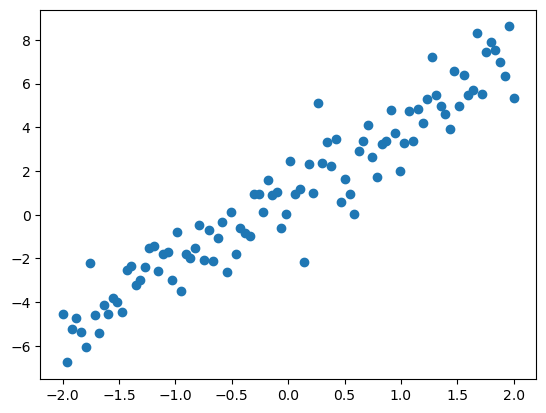

In [5]:
N = 100
x = np.linspace(-2,2,N)
y = f(x) + np.random.randn(N) # our zero man gaussian noise

plt.scatter(x,y);

## Hypothesis Space

Now this our **dataset**. Say we want to fit a line to this dataset, so our **hypothesis** takes the form:

$$h(x) = mx+b $$

This model has **two parameters** that we have to learn: $m$ and $b$. 

Althogh this is not typical in linear regression, we can also call them **weights**:

$$h(x) = w_0 + w_1x$$

Another notational thing that we can do now that will be useful to us later, is introduce a notational convenience: $x_0 = 1$. This lets us rewrite our model as:

$$h(x) = w_0 x_0 + w_1x_1$$

where our original variable $x$ we're now calling $x_1$. 

**Remember!** This is just a "trick" of notation, because $x_0$ is defined to be $1$, so we actually have:

$$
\begin{align}
h(x) &= w_0 x_0 + w_1x_1 \\
     &= w_0 (1) + w_1x_1 \\
     &= w_0 + w_1x_1 \\
     &= b + mx
\end{align}
$$

This notational trick now lets us write out our model in succinct linear algebraic notation as a **dot product** using vectors:

$$
\begin{align}
h(\mathbf{x}) &= \mathbf{w}\cdot\mathbf{x} \\
              &= w_0x_0 + w_1x_1 \\
              &= \mathbf{w}^T \mathbf{x}
\end{align}
$$

Lets quickly remind ourselves about column vectors, row vectors and the dot product:

<div class="info">
    
We usually assume all vectors are written as **column** vectors, meaning they look like this:
$$
\mathbf{a} = 
\begin{bmatrix}
a_0 \\ a_1
\end{bmatrix}
$$

So when we transponse them, they become **row** vectors:
$$
\mathbf{b}^T = 
\begin{bmatrix}
b_0 & b_1
\end{bmatrix}
$$

This lets us write our **dot product** as a vector-vector multiplication of a column vector and a row vector:
$$
\begin{align}
\mathbf{a} \cdot \mathbf{b} &= a_0b_0 + a_1b_1 \\
                            &= \mathbf{a}^T\mathbf{b} \\
                            &= \mathbf{b}^T\mathbf{a}
\end{align}
$$

</div>

So lets summarize: we want to learn a **linear** model for our dataset: 

$$\hat{y}=h(x)=mx+b$$ 

meaning we want a **slope**: $m$, and an **intercept**: $b$. 

We have **restated** this problem in more linear algebraic notation, as wanting to find a **2-dimensional** weight vector: $\mathbf{w}$ for our linear model: 

$$h(\mathbf{x}) = \mathbf{w}^T\mathbf{x}$$

So we can interpret the components of $\mathbf{w}$ as: 

$$
\mathbf{w} = 
\begin{bmatrix}
w_0 \\ w_1
\end{bmatrix}
=
\begin{bmatrix}
b \\ m
\end{bmatrix}
=
\begin{bmatrix}
intercept \\ slope
\end{bmatrix}
$$

---

Now, lets go *one step further* with our notation! Note that as we've specified it above,

$$h(\mathbf{x}) = \mathbf{w}^T\mathbf{x}$$

only specifies a **single** $\hat{y}$, for a **single** example of our dataset: $\mathbf{x}$. 

So, to abuse notation even futher, (trust me, I don't want to but this is how its almost always presented so we might as well get used to it!) we can make this explicity by saying: 

$$\hat{y}_i = h(\mathbf{x}_i) = \mathbf{w}^T\mathbf{x}_i$$

We want to generate our estimates for each input example $\mathbf{x}_i$. We can picture what we want like this:

$$
\begin{align}
    \hat{y}_1 &= h(\mathbf{x}_i) = \mathbf{w}^T\mathbf{x}_i \\
    \hat{y}_2 &= h(\mathbf{x}_2) = \mathbf{w}^T\mathbf{x}_2 \\
    \ldots \\
    \hat{y}_i &= h(\mathbf{x}_i) = \mathbf{w}^T\mathbf{x}_i \\
    \ldots \\
    \hat{y}_N &= h(\mathbf{x}_N) = \mathbf{w}^T\mathbf{x}_N \\
\end{align}
$$

I've laid out suggesting we can do this with linear algebra, and indeed we can! We want to form a **vector** of our estimates: $\mathbf{\hat{y}}$ which of size $(N \times 1)$. To do so, we need to calculate the following operation:

$$
\begin{bmatrix}
    \mathbf{w}^T\mathbf{x}_i \\
    \mathbf{w}^T\mathbf{x}_2 \\
    \mathbf{w}^T\mathbf{x}_i \\
    \mathbf{w}^T\mathbf{x}_N \\
\end{bmatrix}
$$

This is exactly the result of a **matrix-vector** product of our dataset matrix $X$, with our weight vector $\mathbf{w}$!

$$
X\mathbf{w} = 
\begin{bmatrix}
    \mathbf{w}^T\mathbf{x}_i \\
    \mathbf{w}^T\mathbf{x}_2 \\
    \mathbf{w}^T\mathbf{x}_i \\
    \mathbf{w}^T\mathbf{x}_N \\
\end{bmatrix}
$$

We can quickly verify that sizes indeed work out:
$$
\underbrace{X}_{(N \times 2)} \underbrace{\mathbf{w}}_{(2 \times 1)} = 
\begin{bmatrix}
    \mathbf{w}^T\mathbf{x}_i \\
    \mathbf{w}^T\mathbf{x}_2 \\
    \mathbf{w}^T\mathbf{x}_i \\
    \mathbf{w}^T\mathbf{x}_N \\
\end{bmatrix}
$$

So now we have a formula, which lets us a single weight vector $\mathbf{w}$ and apply it to our entire dataset at once, to generate all of our estimates at once:

$$ X\mathbf{w} = \mathbf{\hat{y}}$$

---



## Dataset
Lets take a second to talk about our dataset **matrix** $X$. Above, we did the following to look at our dataset:


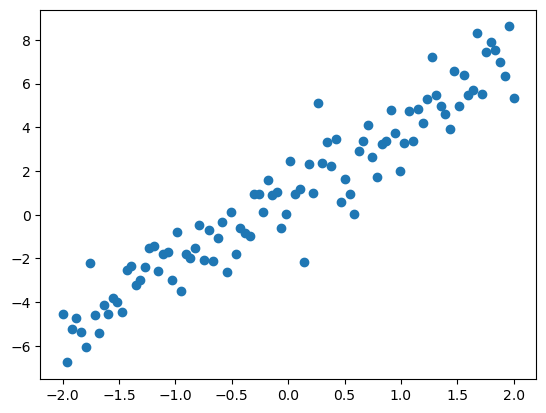

In [6]:
plt.scatter(x,y);

At first glance, we don't see any matrix here! Our $x$'s are only 1 dimensional! Well, recall the convention that $x_0=1$! So our dataset matrix is actually: 

$$
X = 
\begin{bmatrix}
1 & x_1 \\
\ldots \\
1 & x_i \\
\ldots \\
1 & x_N
\end{bmatrix}
$$

where now $i$ is indexing from $1,\ldots,N$ - the size of our dataset. So lets go ahead and form it:


In [7]:
X = np.ones((N,2))
X[:,1] = x
X[0:5,:]

array([[ 1.        , -2.        ],
       [ 1.        , -1.95959596],
       [ 1.        , -1.91919192],
       [ 1.        , -1.87878788],
       [ 1.        , -1.83838384]])

Now lets assemble our output vector:


In [8]:
y = y[:,None]
# or y = y[:, np.newaxis]
print(y.shape)
y[0:5,:]

(100, 1)


array([[-4.54437285],
       [-6.75779464],
       [-5.2087573 ],
       [-4.73313111],
       [-5.35793348]])

#### Broadcasting

::: {.callout-important}
    
**Note**: Its important for this vector to be an actual column vector (i.e. have its last dimension be `1`. Otherwise, a somewhat non-intuitive (unless you are familiar with and love numpy's **array broadcasting** rules) broadcast happens. As an example:
    
:::


In [9]:
a = np.random.rand(3,1)
a.shape,a

((3, 1),
 array([[0.09708829],
        [0.71928046],
        [0.79971499]]))

In [10]:
b = np.random.rand(3)
b.shape,b

((3,), array([0.46586583, 0.67176581, 0.4836771 ]))

As we can see, at first glance these are both vectors of length 3...right? Lets substract them and see what happens:


In [11]:
result = a-b
result.shape,result

((3, 3),
 array([[-0.36877755, -0.57467753, -0.38658881],
        [ 0.25341463,  0.04751465,  0.23560336],
        [ 0.33384915,  0.12794917,  0.31603789]]))

<div class="info">

**You-should-know**: This is **not** what you might except as a *mathematician*, but **you must familiarize yourself with and come to love broadcasting as a Data scientist!**

</div>

To prevent having to squeeze things after a dot product, I think its just easier to ensure that `y` has the proper dimension.

---

## Cost function

Now that we understand our model, we can talk about  how exactly we're going to **learn** what the **best** weights should be.

In order to *learn*, we need a measure of **distance** or **cost** or **quality** of our current guess, which tells us how good/bad were doing so far. As we've discussed in class, a natural loss for regression is the regression loss, or the **mean squared error (MSE)** loss:

$$
C(\mathbf{w}) = \underbrace{\frac{1}{N} \sum_{i=1}^N}_{\text{mean}} \;\; \underbrace{(\hat{y}_i-y_i)^2}_{\text{squared error}}
$$

<div class="info">

**Pause and Ponder:** Often times, you'll see this cost function defined with a $\frac{1}{2N}$ instead of just $\frac{1}{N}$. 
* **Why** do you think that is?
* Do you think that will affect our learning procedure? 
</div>

---



The cost function given above looks a bit strange at first. I've written it as a function of our weight vector $\mathbf{w}$, but $\mathbf{w}$ does not appear on the right hand side, but $\hat{y}_i$ does. Recall, that all of our individual $\hat{y}_i$ are generated from one weight vector. We could also rewrite the above as:

$$
C(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N \;\; (\mathbf{w}^T\mathbf{x}_i-y_i)^2
$$

So, we can now calculate this for out entire dataset! Lets do so below, for a random weight vector:


In [12]:
w_rand = np.random.random(size=(2,1))
w_rand

array([[0.51374312],
       [0.57865621]])

Now, lets loop through all $N$ data points and calculate this cost:


In [13]:
cost = 0
for i in range(N):
    x_i = X[i,:]
    y_hat_i = w_rand.T.dot(x_i)
    error_i = y_hat_i - y[i]
    cost = cost + error_i**2

cost = np.squeeze(cost/N)  # the squeeze just gets rid of empty dimensions
cost

array(10.13753696)

So this is our cost for a random weight vector. Lets define this as a fuction, so we can **plot it over the space of $w_0$ and $w_1$.** 

<div class="info">

**Recall**: this is the same as plotting the cost over the sapce of **intercepts** ($w_0$) and **slopes** ($w_1$)

</div>


In [14]:
def cost(dataset,w):
    N = dataset.shape[0]
    cost = 0
    for i in range(N):
        x_i = dataset[i,:]
        y_hat_i = w.T.dot(x_i)
        error_i = y_hat_i - y[i]
        cost = cost + error_i**2

    return np.squeeze(cost/N)

Lets verify it works as we expect:


In [15]:
cost(X,w_rand)

array(10.13753696)

Perfect - lets now calculate our costs over the entire grid of potential slope and interceps:

**Note:** The below is slow! But right now Im purposefully not vectorizing anything so it follows our intuition


In [16]:
len_w = 100
w_0 = np.linspace(0,2,len_w) # possible bias
w_1 = np.linspace(2,4,len_w) # possible slopes
costs = np.zeros((len_w,len_w))
for i in range(len_w):
    for j in range(len_w):
        current_w = np.asarray([w_0[i],w_1[j]])
        costs[i,j] = cost(X,current_w)

Wow! That took a while!

Now lets actually plot our cost surface along with a contour plot and the real minimum highlighted. 

Note: you can skip the plotting details in this cell if you want.


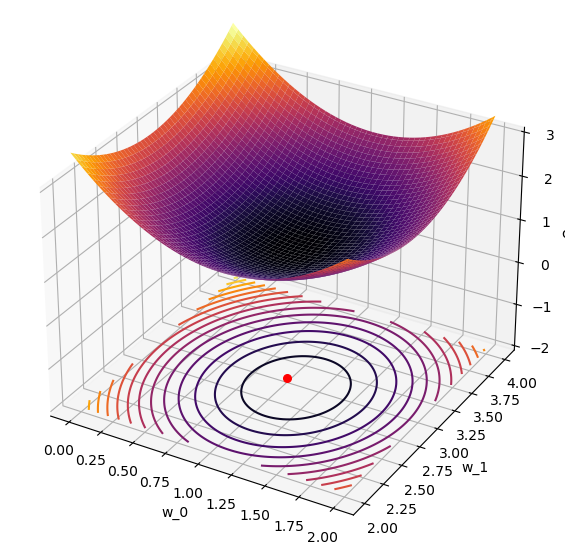

In [17]:
# plotting
W_0, W_1 = np.meshgrid(w_0, w_1)
Costs = costs.reshape(W_0.shape)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('cost')
ax.set_zlim([-2,3])

ax.plot_surface(W_0, W_1, Costs,cmap='inferno');
ax.contour(W_0, W_1, Costs, cmap='inferno', offset=-2,levels=15);
ax.scatter(1,3,-2,s=30,color='r');   # plot the known minimum

So now we can actually see our cost surface as a function of our weight vector!

<div class="info">

**Pause and Ponder**: Why is it that our true minimum shown in red, is **not** the minimum of our cost surface?
    
</div>

---

#### Vectorized Cost function

We've come a long way so far, and we haven't even learned anything! Before we move forward with that, lets **vectorize** our cost function.

<div class="info">
    
**Vectorization** is often used to mean "rewrite in linear-algebraic notation". This results in much faster code, since our numerical libraries have been optimized to operate on vectors/matrices and not for loops!
</div>

The function we just explored was:

$$
C(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^N \;\; (\mathbf{w}^T\mathbf{x}_i-y_i)^2
$$


Before we proceed, lets take a quick asside to remind ourselves of the definition of the **$\mathcal{L}_2$-norm**:

<div class="info">

The $\mathcal{L}_2$-norm of a vector $\mathbf{a}$ is:

$$
    \|\mathbf{a}\|_2 = \sqrt{a_1^2 + \ldots + a_n^2}
$$

We are often interested in the **squared** $\mathcal{L}_2$-norm of a vector:

$$
    \|\mathbf{a}\|_2^2 = a_1^2 + \ldots + a_n^2
$$
  
We are also often interested in the squared $\mathcal{L}_2$-norm of some kind of **distance** or **error** vector:
    
$$
    \|\mathbf{a}-\mathbf{b}\|_2^2 = (a_1-b_1)^2 + \ldots + (a_n-b_n)^2
$$

</div>

Now, lets use the fact that we can calculate our all our $\hat{y}_i$ at once and rewrite the cost in terms of the $\mathcal{L}_2$-norm we just defined above

$$
\begin{align}
    C(\mathbf{w}) &= \frac{1}{N} \| X\mathbf{w} - \mathbf{y} \|_2^2 \\
                  &= \frac{1}{N} \| \mathbf{\hat{y}} - \mathbf{y} \|^2_2 \\
                  &= \frac{1}{N} \left[ (\hat{y}_1 - y_1)^2 + \ldots + (\hat{y}_N-y_N)^2 \right]
\end{align}
$$

which is exactly what we want! So now we can calculate our cost as:


In [18]:
cost = np.linalg.norm(X.dot(w_rand)-y)**2/X.shape[0]
cost

10.137536961317753

This is exactly what we had above! Lets now re-define our vectorized cost function:


In [19]:
def cost(X, y, w):
    return np.linalg.norm(X.dot(w)-y,axis=0)**2/X.shape[0]

Lets re-calculate our costs over a grid and replot it!


In [20]:
len_w = 100
w_0 = np.linspace(0,2,len_w)
w_1 = np.linspace(2,4,len_w)
W_0, W_1 = np.meshgrid(w_0, w_1)

In [21]:
W_0.shape, W_1.shape

((100, 100), (100, 100))

In [22]:
# combine and reshape mesh for calculation
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)

<div class="info">

Pay attention to how much faster this cell is than the double for loop above!
</div>


In [23]:
cost(X,y,wgrid)

array([3.78144022, 3.74421484, 3.7078057 , ..., 3.3598471 , 3.40179731,
       3.44456376])

In [24]:
# calculate on grid, and reshape back for plotting
costs = cost(X,y,wgrid).reshape(W_0.shape)

Wow! That was **fast!** Now lets plot it!


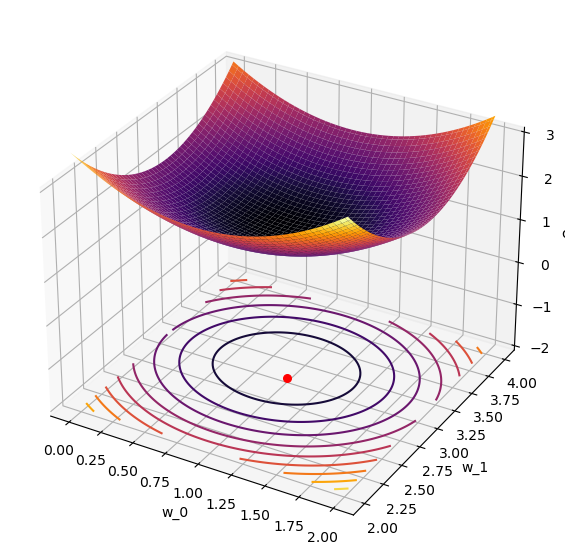

In [25]:
# plotting
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('cost')
ax.set_zlim([-2,3])

ax.plot_surface(W_0, W_1, costs,cmap='inferno');
ax.contour(W_0, W_1, costs, cmap='inferno', offset=-2,levels=10);
ax.scatter(1,3,-2,s=30,color='r');   # plot the known minimum

It works!

---



## Gradient of our cost

Now, we can really get going! Lets start by giving the **gradient** of this cost function (recall: we calculated this in class!). Lets also call this cost what it is, the **in-sample error**:

$$
E_{in}(\mathbf{w}) = C(\mathbf{w}) = \frac{1}{N} \| X\mathbf{w} - \mathbf{y} \|_2^2 
$$

So its gradient is: 

$$
\begin{align}
    \nabla E_{in}(\mathbf{w}) &= \frac{2}{N}(X^TX\mathbf{w} - X^T\mathbf{y})
\end{align}
$$

**Recall** an earlier pause-and-ponder where I asked about the definition of the cost function with a $\frac{1}{2N}$ vs $\frac{1}{N}$!


Lets also note an underappreciated property of this function which will become relevant later:

<div class="info">
    
**Pause-and-ponder:** This gradient is a function of our **entire dataset**! This means that at each point in weight space, to calculate the gradient we need to proces our entire dataset! 

</div>

Keep that point in mind as we will come back to it later!


---

## Gradient Descent for Linear Regression

Now we have all the pieces together to start talking about and implement gradient descent! Recall the **weight update** equation we gave in class:

$$\boldsymbol{w}(t+1) = \boldsymbol{w}(t) + \eta \hat{\boldsymbol{v}}$$

where $\hat{\boldsymbol{v}}$ is the **unit-vector** in the **direction** we want to step.

For **gradient descent**, this becomes:


<div class="info">
    
The **gradient descent algorithm** is just a step in the **direction** of the **negative gradient**:
$$\boldsymbol{w}(t+1) = \boldsymbol{w}(t) -\eta\cdot\nabla f(\boldsymbol{w}(t))$$
</div>

---



Lets look at this for special case of linear regression, by starting with the weight update equation:

$$
\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla E_{in}
$$

Lets move $\mathbf{w}_t$ to the other side so we can focus on the **change** in our weights:

$$
\begin{align}
    \Delta \mathbf{w} &= \mathbf{w}_{t+1} - \mathbf{w}_t \\
                      &= - \eta \nabla E_{in} \\
                      &= - \eta \frac{2}{N} (X^TX\mathbf{w} - X^T\mathbf{y})
\end{align}
$$

We can now write the GD algorithm for **linear regression**:

<div class="info">
    
The gradient descent algorithm for linear regression is:
    
$$
\begin{align}
\boldsymbol{w}(t+1) &= \boldsymbol{w}(t) -\eta \nabla E_{in} \\
                    &= - \eta \frac{2}{N} (X^TX\mathbf{w} - X^T\mathbf{y})
\end{align}
$$
</div>


Lets first define a function to calculate this gradient:


In [26]:
def cost_grad(X,y,w):
    N = X.shape[0]
    return (2/N)*(X.T.dot(X).dot(w)-X.T.dot(y))

Out of curiosity, lets visualize it! 


In [27]:
len_w = 100
w_0 = np.linspace(0,2,len_w)
w_1 = np.linspace(2,4,len_w)
W_0, W_1 = np.meshgrid(w_0, w_1)

# combine and reshape mesh for calculation
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)

In [28]:
# calculate on grid, and reshape back for plotting
costs = cost(X,y,wgrid).reshape(W_0.shape)

In [29]:
# calculate grad on grid, and reshape back for plotting
grad_costs = cost_grad(X,y,wgrid).reshape(2,W_0.shape[0],W_0.shape[1])

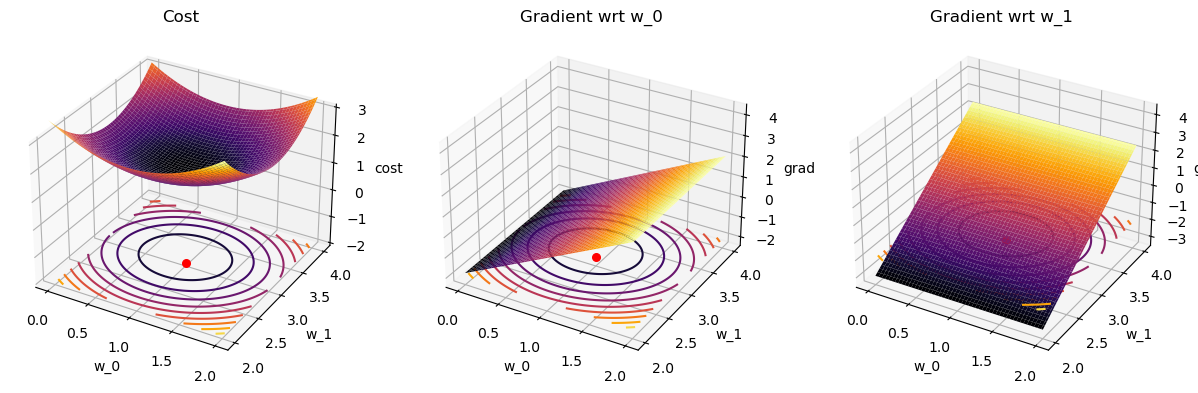

In [30]:
# plotting
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(131,projection='3d')
ax1.set_xlabel('w_0')
ax1.set_ylabel('w_1')
ax1.set_zlabel('cost')
ax1.set_zlim([-2,3])
ax1.set_title('Cost')

ax1.plot_surface(W_0, W_1, costs,cmap='inferno');
ax1.contour(W_0, W_1, costs, cmap='inferno', offset=-2,levels=10);
ax1.scatter(1,3,-2,s=30,color='r');   # plot the known minimum

ax2 = plt.subplot(132, projection='3d', sharex = ax1, sharey=ax1)
ax2.set_xlabel('w_0')
ax2.set_ylabel('w_1')
ax2.set_zlabel('grad')
ax2.set_title('Gradient wrt w_0')
ax2.plot_surface(W_0, W_1, grad_costs[0,:],cmap='inferno');
ax2.contour(W_0, W_1, costs, cmap='inferno', offset=-2,levels=10);
ax2.scatter(1,3,-2,s=30,color='r');   # plot the known minimum

ax3 = plt.subplot(133, projection='3d', sharex = ax1, sharey=ax1)
ax3.set_xlabel('w_0')
ax3.set_ylabel('w_1')
ax3.set_zlabel('grad')
ax3.set_title('Gradient wrt w_1')
ax3.plot_surface(W_0, W_1, grad_costs[1,:],cmap='inferno');
ax3.contour(W_0, W_1, costs, cmap='inferno', offset=-2,levels=10);
ax3.scatter(1,3,-2,s=30,color='r');   # plot the known minimum

<div class="info">

**Pause-and-ponder**: What does this mean? 🧐 Think about this!
</div>


---

### Implementation
Lets actually implement our weight updates now!

In [31]:
def gradient_descent(dataset, labels, w_init=None, eta=None, max_iter=300, quiet=False):
    if w_init is None:
        w_init = np.random.rand(dataset.shape[1],1)
    if eta is None:
        eta = 0.01
    
    # clean up initial point sizes:
    w_init = np.asarray(w_init).reshape(dataset.shape[1],1)
    
    # gradient descent params
    delta = 0.001
    delta_w = 1
    iterations = 0
    
    # save weights and costs along path
    wPath = [w_init]
    cPath = [cost(dataset,labels,w_init)]
        
    # take first step
    w_old = w_init
    
    # perform GD
    while True:
        # check to see if you should terminate
        if iterations > max_iter:
            if not quiet: print("terminating GD after max iter:",max_iter)
            break
            
        if delta_w < delta:
            if not quiet: print(f"terminating GD after {iterations} iterations with weight change of {delta}.")
            break
             
        # update your weights
        # STEP 1 
        w_new = w_old - eta* cost_grad(dataset,labels,w_old)
        
        # update paths
        wPath.append(w_new)
        cPath.append(cost(dataset,labels,w_new))
        
        # update iteration and weight change
        iterations += 1
        delta_w = np.linalg.norm(w_new - w_old)
        
        # STEP 2
        # make your previous new weights the current weights
        w_old = w_new
    
    # clean up path variables
    wPath = np.squeeze(np.asarray(wPath))
    cPath = np.squeeze(np.asarray(cPath))
    
    return w_new, wPath, cPath

In [32]:
w_gd, wPath_gd, cPath_gd = gradient_descent(X, y, [0.25,2.4], eta = 0.2)
w_gd

terminating GD after 12 iterations with weight change of 0.001.


array([[0.92994594],
       [3.11226582]])

---



### Plot Path
Now lets plot the **path** GD took!


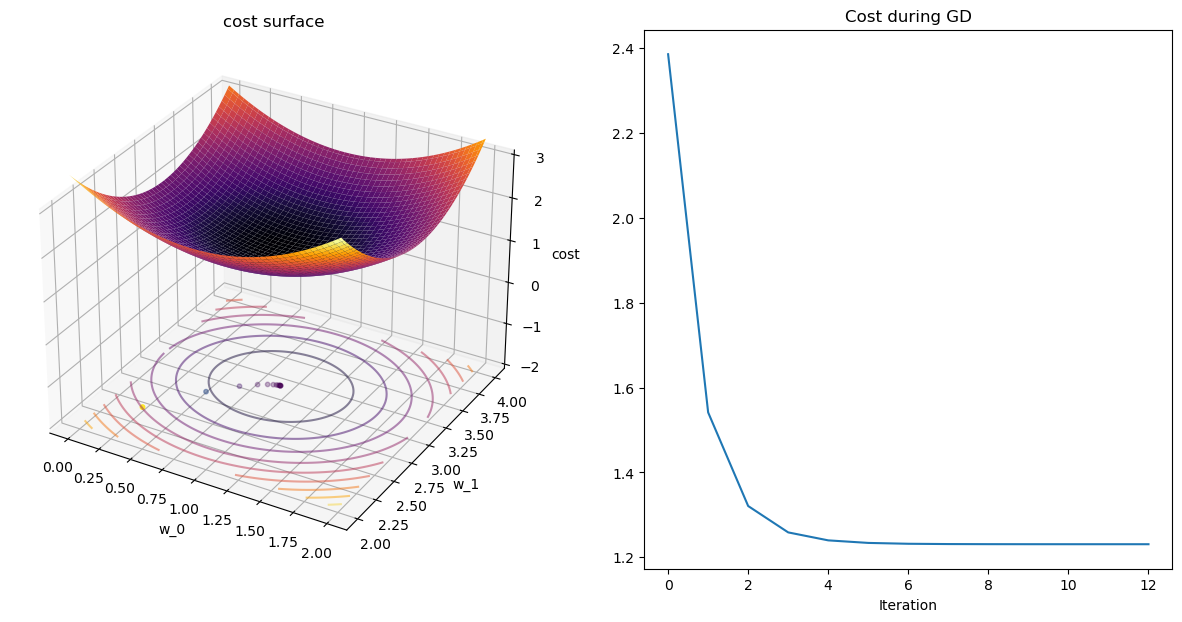

In [33]:
# plotting
len_w = 100
w_0 = np.linspace(0,2,len_w)
w_1 = np.linspace(2,4,len_w)
W_0, W_1 = np.meshgrid(w_0, w_1)

# combine and reshape mesh for calculation
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)

# calculate on grid, and reshape back for plotting
costs = cost(X,y,wgrid).reshape(W_0.shape)

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121,projection='3d')
ax1.set_xlabel('w_0')
ax1.set_ylabel('w_1')
ax1.set_zlabel('cost')
ax1.set_zlim([-2,3])
ax1.set_title("cost surface")

ax1.scatter(wPath_gd[:,0],wPath_gd[:,1],-2,s=10,c=cPath_gd);
ax1.plot_surface(W_0, W_1, costs,cmap='inferno');
ax1.contour(W_0, W_1, costs, cmap='inferno', offset=-2,levels=10,alpha=0.5);

ax2 = fig.add_subplot(122);
ax2.plot(cPath_gd);
ax2.set_title("Cost during GD")
ax2.set_xlabel("Iteration");

Lets define a quick plotting function to make it easier to re-use: 


In [34]:
def plot_path(wPath,cPath,colorby='cost'):
    if colorby == 'cost':
        colorer = cPath
    else:
        colorer = range(len(wPath))
    # plotting
    len_w = 100
    w_0 = np.linspace(0,2,len_w)
    w_1 = np.linspace(2,4,len_w)
    W_0, W_1 = np.meshgrid(w_0, w_1)

    # combine and reshape mesh for calculation
    wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)

    # calculate on grid, and reshape back for plotting
    costs = cost(X,y,wgrid).reshape(W_0.shape)
    
    
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121,projection='3d')
    ax1.set_xlabel('w_0')
    ax1.set_ylabel('w_1')
    ax1.set_zlabel('cost')
    ax1.set_zlim([-2,3])
    ax1.scatter(wPath[:,0],wPath[:,1],-2,s=10,c=colorer,cmap='inferno');
    ax1.plot_surface(W_0, W_1, costs,cmap='inferno');
    ax1.contour(W_0, W_1, costs, cmap='inferno', offset=-2,levels=10,alpha=0.5);
    
    ax2 = fig.add_subplot(122);
    ax2.plot(cPath);
    ax2.set_title("Cost during training")
    ax2.set_xlabel("Iteration");

Go back, and try rerunning gradient descent with different initial values and plot:


terminating GD after 151 iterations with weight change of 0.001.


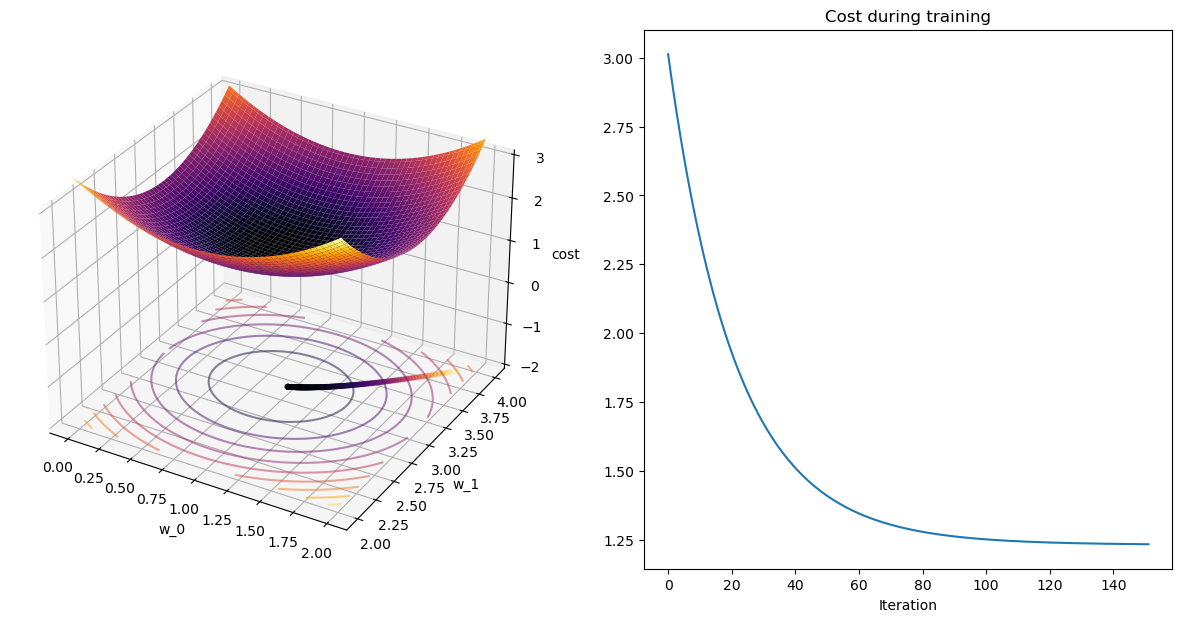

In [35]:
_,wPath_gd,cPath_gd = gradient_descent(X,y,[1.9,3.9])
plot_path(wPath_gd,cPath_gd)

In [36]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider

# @interact(w_0=(0,2,0.1), w_1=(2,4,0.1))
def interactive_gd(w_0,w_1):
    _,wPath_gd,cPath_gd = gradient_descent(X,y,[w_0,w_1])
    plot_path(wPath_gd,cPath_gd)

interact(interactive_gd, w_0=FloatSlider(min=0,max=2,step=0.1,continous_update=False),
                         w_1=FloatSlider(min=2,max=4,step=0.1,continous_update=False));

interactive(children=(FloatSlider(value=0.0, description='w_0', max=2.0), FloatSlider(value=2.0, description='…

Ok. Now we have should have a much better grasp of Gradient Descent for Linear Regression!

## Multivarite Linear Regression

The best part of the formulism above, is that it now works for higher order models! For example, lets run the same analysis as above, except not we are tring to fit a 3rd-order polynomial:


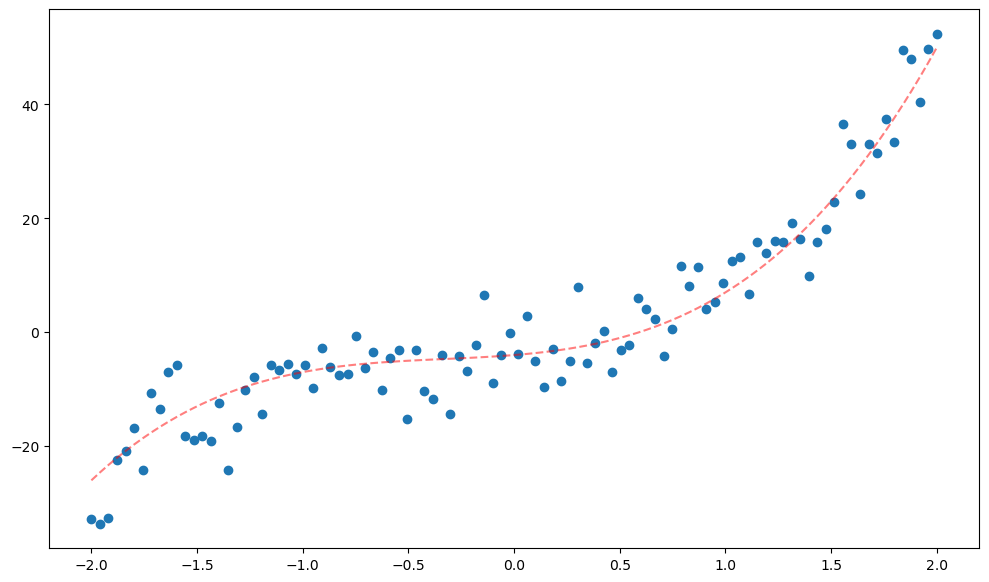

In [37]:
def f(x):
    return 4*x**3 + 4*x**2 + 3*x - 4

x = np.linspace(-2,2,100)

y = f(x) + np.random.randn(len(x))*5

plt.figure(figsize=(12,7))
plt.scatter(x,y);
plt.plot(x,f(x),'--r',alpha=0.5);

The model we are trying to fit here can now be written as:

$$
h(\mathbf{w}) = w_0 + w_1x + w_2x^2 + w_3x^3
$$

So just like for a line, we were learning 2 parameters, for a 3-rd order polynomial we are learning 4:

$$
h(\mathbf{w}) = \mathbf{w}^T\mathbf{x}
$$

For

$$
\mathbf{w} = 
\begin{bmatrix}
w_0 \\ w_1 \\ w_2 \\ w_3
\end{bmatrix},
\;\;\quad\;\;
\mathbf{x} = 
\begin{bmatrix}
1 \\ x \\ x^2 \\ x^3
\end{bmatrix}
$$

Lets form our dataset/design matrix as above by stacking:


In [38]:
X = np.hstack((x[:,np.newaxis]*0+1,
               x[:,np.newaxis], 
               x[:,np.newaxis]**2, 
               x[:,np.newaxis]**3))

So now each **row** of $X$ is a sample of our dataset, and each **column** is a dimension:


In [39]:
print("sample:",X[1,:])

sample: [ 1.         -1.95959596  3.84001632 -7.52488047]


Lets also redefine our $y$'s as a column vector:


In [40]:
y = y[:,np.newaxis]
y.shape

(100, 1)

Because of how we defined our `cost` and `cost_grad` functions, we should be able to use them **without modification!**. Lets calculate the cost on a random 4 dimensional vector:


In [41]:
w_rand = np.random.rand(4,1)*5
w_rand

array([[4.40486757],
       [2.19318454],
       [2.83438899],
       [4.02340168]])

In [42]:
cost(X,y,w_rand)

array([77.98811223])

Perfect! Unfortunately, we can't easily visualize it, so lets instead plot the GD procedure as the polynomial we are fitting:


In [43]:
w_gd,wPath_gd,cPath_gd = gradient_descent(X,y)
w_gd

terminating GD after max iter: 300


array([[-3.4482133 ],
       [ 3.50132037],
       [ 3.62600224],
       [ 4.17202869]])

Recall, this weight vector now **defines a polynomial!**. Lets plot the polynomial given by our final weight vector:

Note: `poly1d` expects the coefs in decreasing order, so we have to reverse our weight vector:


In [44]:
coefs = np.flip(np.squeeze(w_gd))
poly_fin = np.poly1d(coefs)

In [45]:
poly_fin

poly1d([ 4.17202869,  3.62600224,  3.50132037, -3.4482133 ])

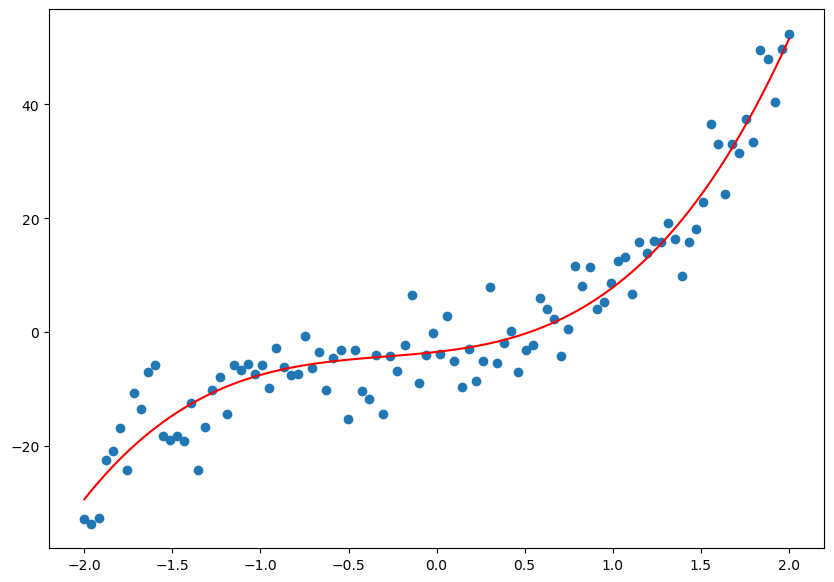

In [46]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(x,y);
ax1.plot(x,poly_fin(x),'r');

Not bad! Lets plot the **path** that GD took, in terms of our polynomials!


In [52]:
if regenerate_anim:
    fig = plt.figure(figsize=(10,7))

    ax1 = fig.add_subplot(111)
    ax1.scatter(x,y);
    line, = ax1.plot([],[],'--r')

    def animate(i):
        coefs = np.flip(np.squeeze(wPath_gd[i]))
        poly_fin = np.poly1d(coefs)
        line.set_data(x,poly_fin(x));
        ax1.set_title('Iteration: %d - %.2f x^3 + %.2f x^2 + %.2f x + %.2f' % (i, coefs[0], coefs[1], coefs[2], coefs[3]))
        return line

    plt.close()
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(wPath_gd), interval=100)
    # HTML(anim.to_html5_video())
    anim.save('multi_lin_reg.mp4')

Video('multi_lin_reg.mp4',width=800)

---

# Stochastic Gradient Descent

We just got done learning about Gradient Descent and implemented it for a multivariate linear regression. Lets restate a pause-and-ponder point I gave above here again:

<div class="info">
    
**Pause-and-ponder:** Gradient descent, as given above, is a function of our **entire dataset**! This means that at each point in weight space, to calculate the gradient we need to proces our entire dataset! 

</div>


This is actually called **Batch Gradient Descent**, because it operates on the entire **batch** of data at once. We have to calculate the gradient **at every point in our dataset** and average them all together everytime. If our dataset is massive, this quickly becomes impractical! 

So, at the other end of Batch GD is Stochastic Gradient Descent (SGD), which calculates the gradient at just **one point**! 

<div class="info">
    
**Note**: **SGD** as defined here works on just 1 sample. **Mini-batch**, as we will see below, works on mini-batches of our dataset. Often, when people say **SGD** they mean **mini-batch**, or **mini-batch-SGD**.

</div>

That is clearly an **estimate** for our gradient, but imagine just how **noisy** it must be! 

Lets remind ourselves about our `cost` and `cost_grad` implementations by inspecting their source:

In [48]:
import inspect
print(inspect.getsource(cost))
print(inspect.getsource(cost_grad))

def cost(X, y, w):
    return np.linalg.norm(X.dot(w)-y,axis=0)**2/X.shape[0]

def cost_grad(X,y,w):
    N = X.shape[0]
    return (2/N)*(X.T.dot(X).dot(w)-X.T.dot(y))



Note, we didn't redefine any new functions here, we just printed their original source code as defined above. 

### SGD Cost

So we see that they are indeed in terms of the **entire** dataset. Lets define new versions here, specifically for SGD.

Recall for GD, the cost was:

$$
C(\mathbf{w})_{gd} = \frac{1}{N} \sum_{i=1}^N \;\; (\mathbf{w}^T\mathbf{x}_i-y_i)^2
$$

Lets rewrite it to make it a bit more explicit:

$$
C(\mathbf{w})_{gd} = \frac{1}{N} \sum_{i=1}^N \; \color{red}{C_i}(\mathbf{w})
$$

So we see in GD, were evaluating a **point-wise cost** on our entire dataset. In SGD, we only want to evaluate it on **one-point**. So lets write out the cost, and emphasize the dependence on 1 data point:

$$
\begin{align}
C(\mathbf{w},\color{red}{x_i,y_i})_{sgd} &= \color{red}{C_i}(\mathbf{w})\\
                    &= (\mathbf{w}^T\color{red}{\mathbf{x}_i-y_i})^2
\end{align}
$$


Now we can implement this cost, and its gradient:

In [49]:
def cost_sgd(x_i, y_i, w):
    return (w.T.dot(x_i) - y_i)**2

In [50]:
def cost_grad_sgd(x_i, y_i, w):
    return 2*x_i*(w.T.dot(x_i)-y_i)

---

## Implementation

Now we are ready to describe the full SGD algorithm. Since we are estimating our gradient at each training sample, we now define a new term:

<div class="info">

**Def**: An **epoch** is a full run of a learning procedure through the entire training set. 
    
</div>


So we can (and often must) take multiple **epochs** of training. The tradeoff is that each iteration is now must faster!

Now we can describe the algorithm as: 

<div class="info">

The **SGD algorithm** is: 
    
for each `epoch`:

* Randomly shuffle the `training_set`
* for each `sample` in `training_set`
    * $w_{t+1} = w_{t} - \eta \; \nabla C_i(\mathbf{w}_t)$
    
</div>

Lets implement that below

In [51]:
A = np.arange(9).reshape(3,3)
A

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [52]:
indices = np.random.permutation(3)
indices

array([1, 2, 0])

In [53]:
A[indices]

array([[3, 4, 5],
       [6, 7, 8],
       [0, 1, 2]])

In [54]:
A

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [55]:
def sgd(dataset, labels, w_init=None, eta=None, epochs=5):
    if w_init is None:
        w_init = np.random.rand(dataset.shape[1],1)
    if eta is None:
        eta = 1e-2
        
    # dataset
    N = dataset.shape[0]
    d = dataset.shape[1]
    
    # clean up initial point sizes:
    w_init = np.asarray(w_init).reshape(d,1)
    
    # SGD params - Note their difference from GD
    delta = 1e-10
    max_iter = 1000
    
    # initialzie loop variables
    delta_w = 1
    iterations = 0

    # save weights and costs along path
    wPath = [w_init]

    # calc cost at that initial value
    idx = np.random.randint(N)
    x_i = dataset[np.newaxis,idx,:].T
    y_i = labels[idx,:]
    cPath = [cost_sgd(x_i,y_i,w_init)]
        
    # take first step
    w_old = w_init
    
    # epochs of training
    for epoch in range(epochs):
        
        # shuffle the dataset - note we do this by shuffling indices
        indices = np.random.permutation(N)
        shuffled_dataset = dataset[indices,:]
        shuffled_labels = labels[indices,:]
        # NOTE: try commenting out this line above and seeing how it behaves
        
        # for each sample
        for i in range(N):
            # np.newaxis is there to deal with the 1 for the row size
            curr_sample = shuffled_dataset[i,:]
            curr_sample = curr_sample[np.newaxis].T
            curr_label = shuffled_labels[i,:]
            
            # update your weights with the grad at one sample
            grad = cost_grad_sgd(curr_sample,curr_label,w_old)
            w_new = w_old - eta * grad
            
            # update paths
            wPath.append(w_new)
            cPath.append(cost_sgd(curr_sample,curr_label,w_new))
            
            # calculate weight change
            # NOTE to me: ask a HW question here!! 
            delta_w = np.linalg.norm(w_new - w_old)
            
            # make your previous new weights the current weights
            w_old = w_new
        
        # at end of epoch, check to see if you should terminate
        if delta_w < delta:
            break
    
    # clean up path variables
    wPath = np.squeeze(np.asarray(wPath))
    cPath = np.squeeze(np.asarray(cPath))
    
    print(f"terminating SGD after {epoch} epochs with weight change of {delta_w:0.5f}.")
    
    return w_new, wPath, cPath

---

## SGD on Linear Regression

Lets re-define our simple linear regression from above and see how we do. This time, lets make a function to make it easier to setup comparisons below:

In [56]:
def lin_reg():
    def f(x):
        return 3*x + 1
    N = 100
    x = np.linspace(-2,2,N)
    y = f(x) + np.random.randn(N) # our zero man gaussian noise
    
    X = np.ones((N,2))
    X[:,1] = x
    
    y = y[:,np.newaxis]

    return x,X,y,f

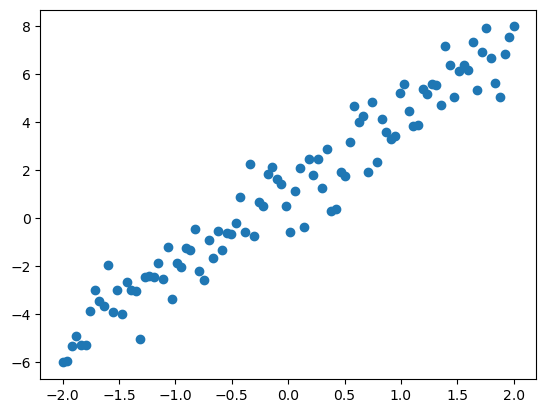

In [57]:
x,X,y,f = lin_reg()
plt.scatter(x,y);

In [58]:
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=[0.75,2.5],eta=1e-2,epochs=100)
w_sgd

terminating SGD after 99 epochs with weight change of 0.03233.


array([[1.04826202],
       [3.13976719]])

### Plot
Lets plot it! 

terminating SGD after 9 epochs with weight change of 0.01851.
[[1.16979153]
 [3.05990881]]


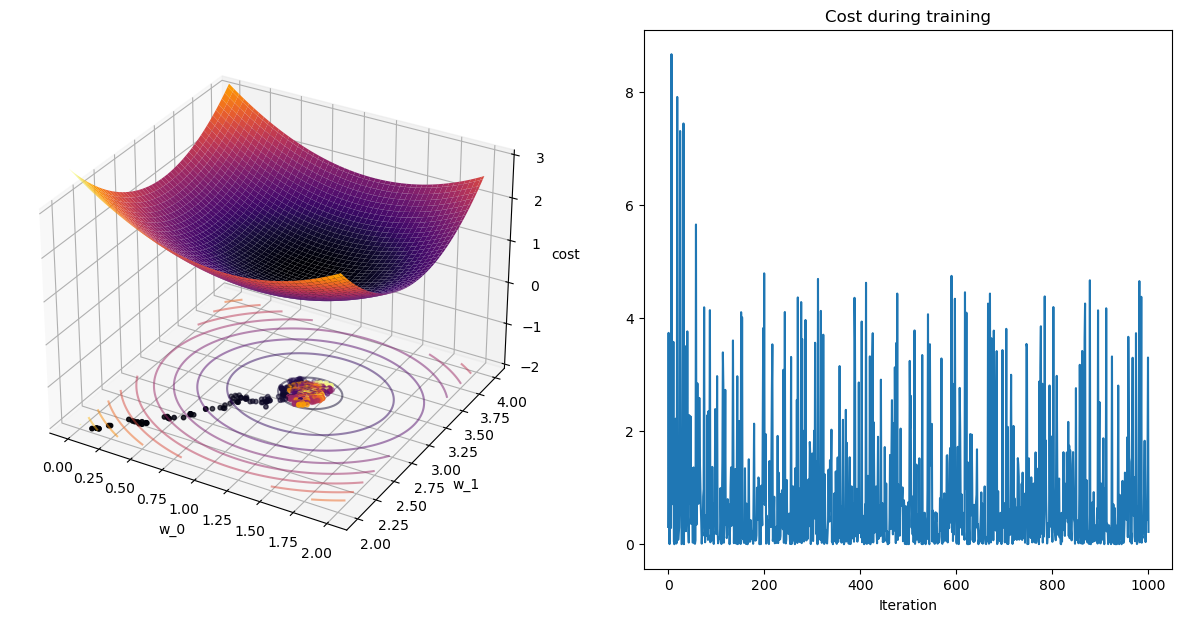

In [59]:
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=[0.1,2],eta=1e-2,epochs=10)
print(w_sgd)
plot_path(wPath_sgd,cPath_sgd,colorby='iter')

<div class="info">
    
**Pause-and-ponder**: What do you notice about this procedure?   
    
</div>

Go back and re-run this procedure with different values for your parameters of interest! 

### Comparison

Lets compare both of them! 

terminating GD after 161 iterations with weight change of 0.001.
terminating SGD after 199 epochs with weight change of 0.00005.


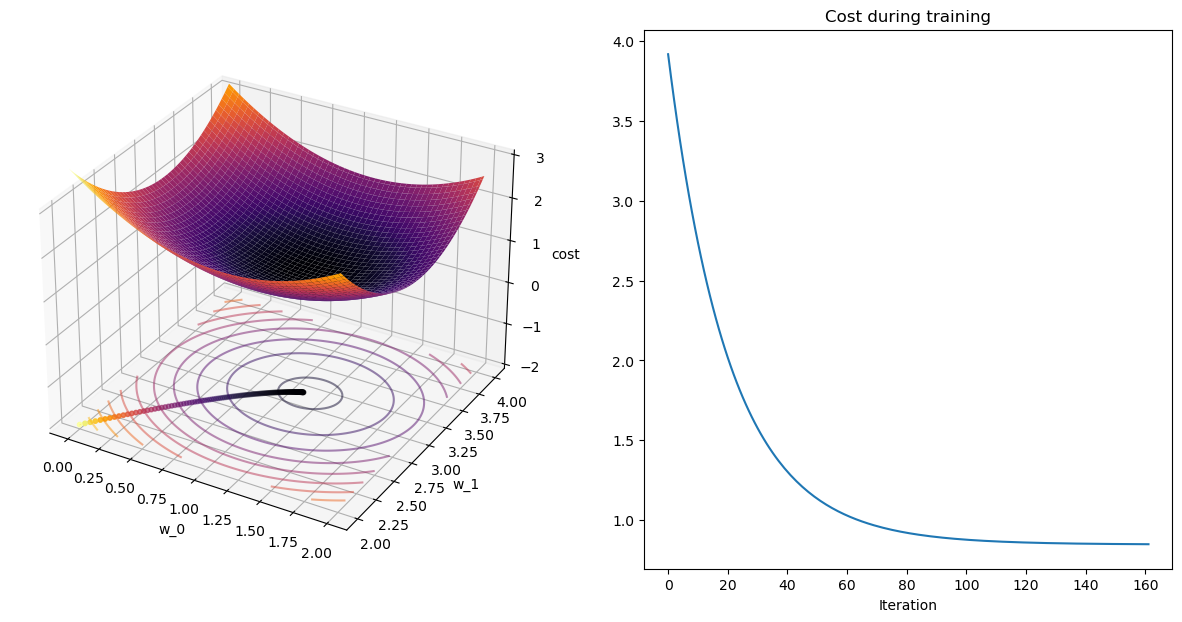

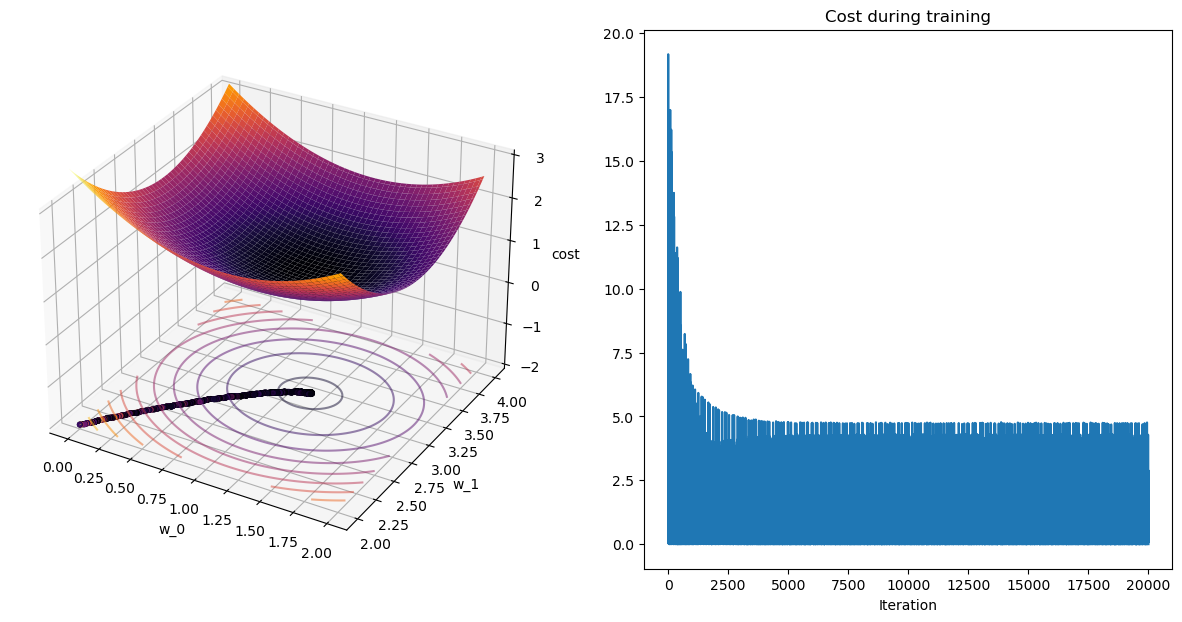

In [60]:
w_init = [0,2]
w_gd,wPath_gd,cPath_gd = gradient_descent(X,y,w_init=w_init)
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=w_init,eta=1e-3/2,epochs=200)

plot_path(wPath_gd,cPath_gd);
plot_path(wPath_sgd,cPath_sgd);

Lets look at the contour plots:

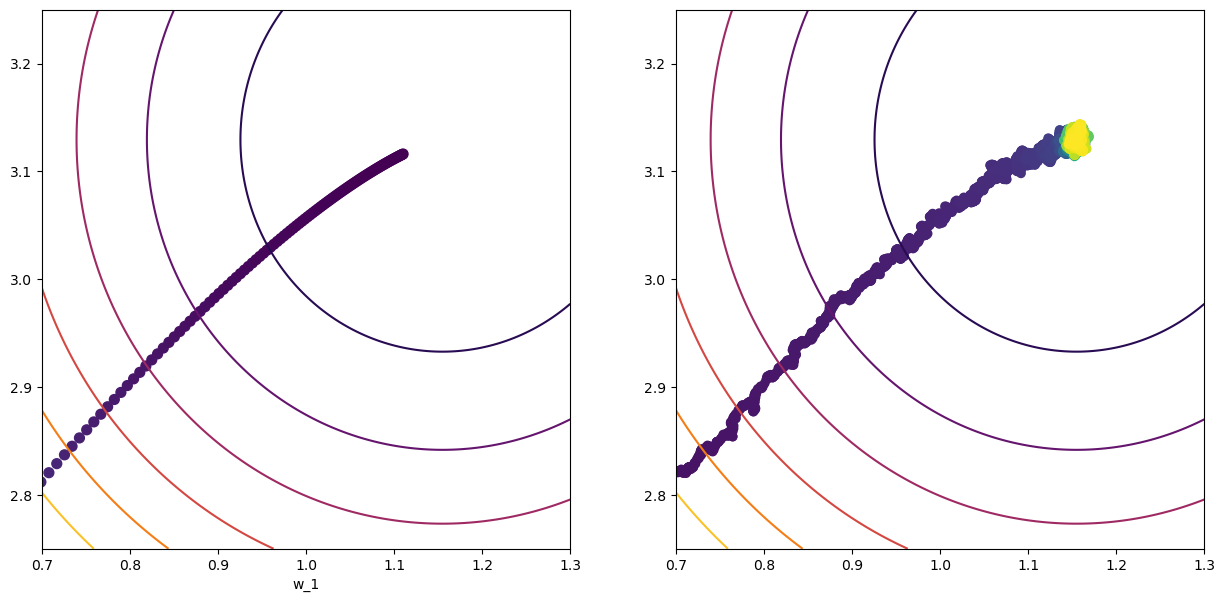

In [61]:
num_points = 300
w_0 = np.linspace(0.7,1.3,num_points)
w_1 = np.linspace(2.75,3.25,num_points)
W_0,W_1 = np.meshgrid(w_0,w_1)
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)
costs = cost(X,y,wgrid).reshape(W_0.shape)

plt.figure(figsize=(15,7));
ax1 = plt.subplot(121)
ax1.contour(W_0, W_1, costs, cmap='inferno');
ax1.set_xlabel('w_0');
ax1.set_xlabel('w_1');
ax1.set_xlim([0.7,1.3])
ax1.set_ylim([2.75,3.25])
ax1.scatter(wPath_gd[:,0],wPath_gd[:,1], s=50,c=cPath_gd);

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
ax2.contour(W_0, W_1, costs, cmap='inferno');
ax2.scatter(wPath_sgd[:,0],wPath_sgd[:,1], c=range(len(wPath_sgd)));

<div class="info">
    
**Pause-and-ponder**: What do you notice?
    
</div>

---

## SGD on Polynomial Regression

As above, lets redefine our polynomial regression problem. This time, lets make it a function to make it easier to compare below.

In [62]:
def poly_reg():
    def f(x):
        return 4*x**3 + 4*x**2 + 3*x - 4
    x = np.linspace(-2,2,100)
    y = f(x) + np.random.randn(len(x))*5
    
    X = np.hstack((x[:,np.newaxis]*0+1,
               x[:,np.newaxis], 
               x[:,np.newaxis]**2, 
               x[:,np.newaxis]**3))
    
    y = y[:,np.newaxis]
    
    return x,X,y,f

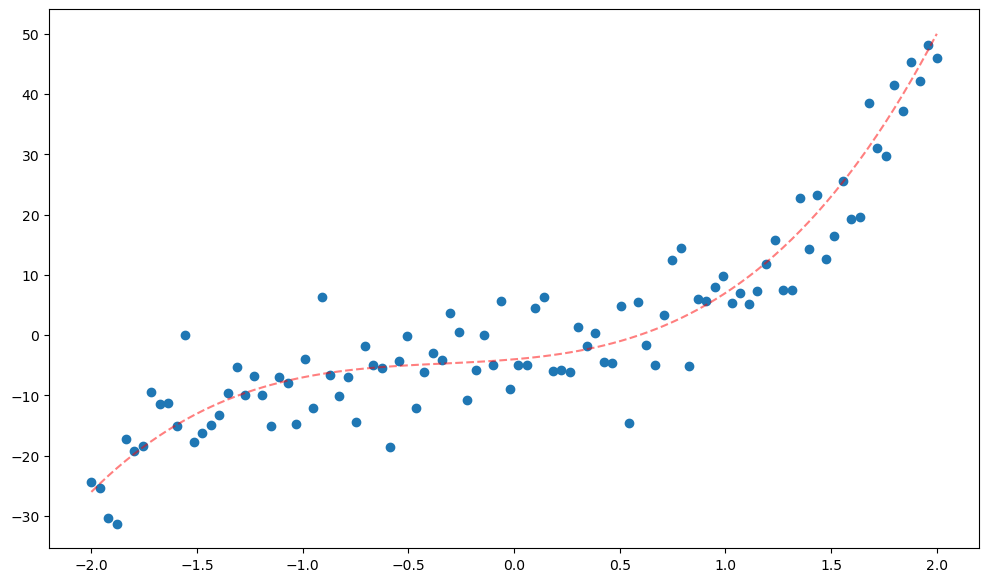

In [63]:
x,X,y,f = poly_reg()
plt.figure(figsize=(12,7))
plt.scatter(x,y);
plt.plot(x,f(x),'--r',alpha=0.5);

Now we can run them both and see!

In [64]:
w_init = [0,0,0,0]
w_gd,wPath_gd,cPath_gd = gradient_descent(X,y,w_init=w_init)
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=w_init,eta=1e-2,epochs=100)

w_gd,w_sgd

terminating GD after max iter: 300
terminating SGD after 99 epochs with weight change of 0.16115.


(array([[-3.37519071],
        [ 2.35485563],
        [ 3.40590893],
        [ 4.0224176 ]]),
 array([[-4.26754354],
        [ 3.14637804],
        [ 3.39303763],
        [ 5.26249499]]))

## Plot it

Before we plot the path, lets plot the overall costs:

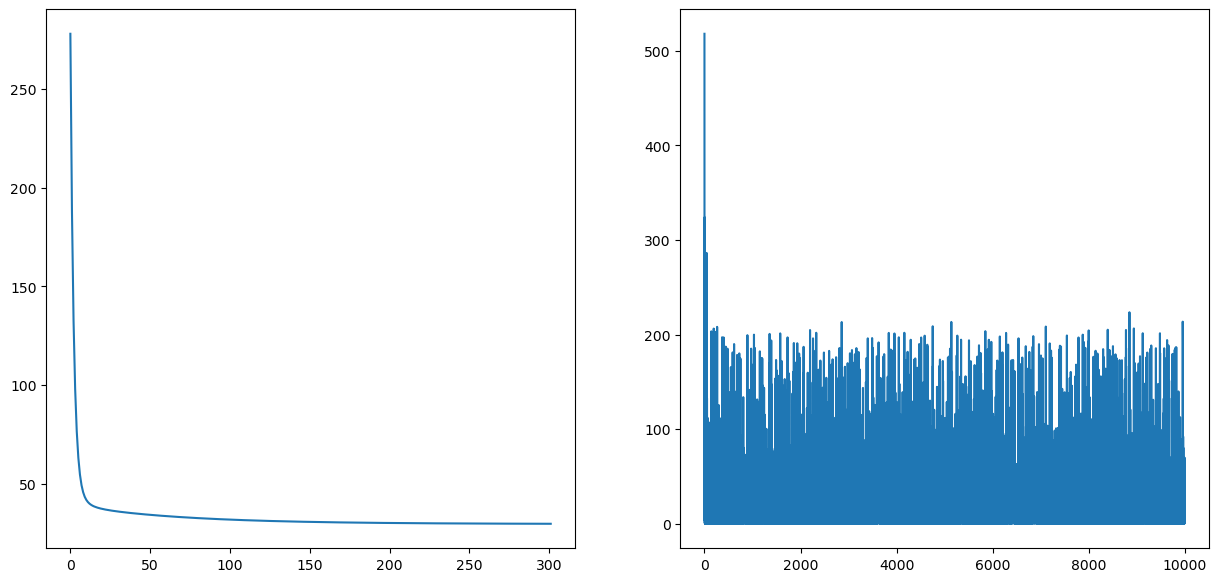

In [65]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(cPath_gd);
ax2.plot(cPath_sgd);

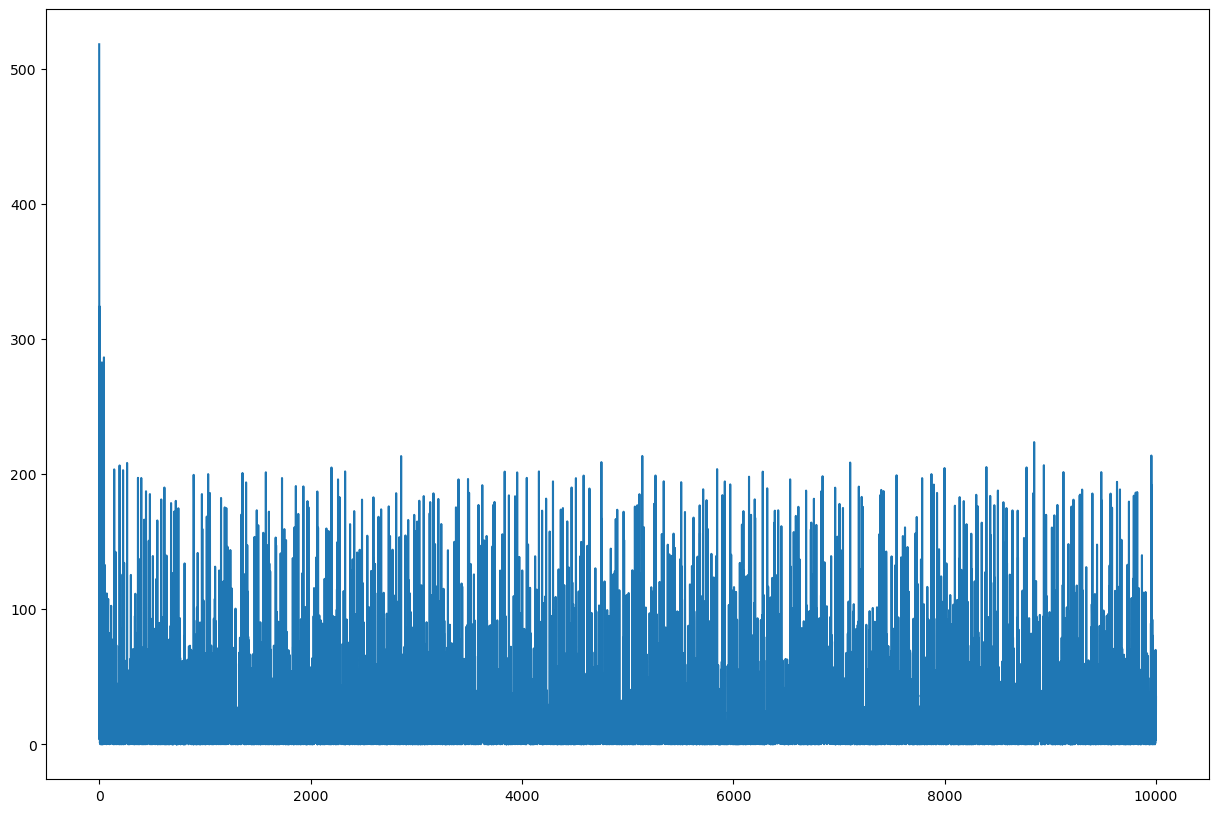

In [66]:
plt.figure(figsize=(15,10))
plt.plot(cPath_sgd)

Now we can plot the path:

In [50]:
if regenerate_anim:
    fig = plt.figure(figsize=(20,7))

    ax1 = fig.add_subplot(121)
    ax1.scatter(x,y);

    ax2 = fig.add_subplot(122)
    ax2.scatter(x,y);



    line1, = ax1.plot([],[],'--r')
    line2, = ax2.plot([],[],'--r')


    num_frames = 50
    gd_frames = np.linspace(0,len(wPath_gd)-1,num_frames).astype(int)
    sgd_frames = np.linspace(0,len(wPath_sgd)-1,num_frames).astype(int)

    # abs_cost_diff = np.abs(cPath_sgd[sgd_frames] - cPath_gd[gd_frames])

    # # ax3 = fig.add_subplot(133)
    # # ax3.plot(range(num_frames),abs_cost_diff)
    # # scat3 = ax3.scatter([],[],s=100)

    def animate(i):
        gd_frame = gd_frames[i]
        sgd_frame = sgd_frames[i]

    #     abs_cost_diff[i] = np.abs(cPath_sgd[sgd_frame] - cPath_gd[gd_frame])

        coefs_gd = np.flip(np.squeeze(wPath_gd[gd_frame]))
        coefs_sgd = np.flip(np.squeeze(wPath_sgd[sgd_frame]))

        poly_gd = np.poly1d(coefs_gd)
        poly_sgd = np.poly1d(coefs_sgd)

        line1.set_data(x,poly_gd(x));
        ax1.set_title('GDIteration: %d - %.2f x^3 + %.2f x^2 + %.2f x + %.2f' % (i, coefs_gd[0], coefs_gd[1], coefs_gd[2], coefs_gd[3]))

        line2.set_data(x,poly_sgd(x));
        ax2.set_title('SGD Iteration: %d - %.2f x^3 + %.2f x^2 + %.2f x + %.2f' % (i, coefs_sgd[0], coefs_sgd[1], coefs_sgd[2], coefs_sgd[3]))


        return line1, line2

    plt.close()
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=num_frames, interval=100)
    # HTML(anim.to_html5_video())
    anim.save('multi_lin_reg_sgd.mp4')
Video('multi_lin_reg_sgd.mp4',width=800)

<div class="info">

**Pause-and-ponder:** What do you observe? Go back and mess around with the setup and compare!

</div>

**Note:** Ask for a plot of the "error-in-each-dimension" like we discussed in class

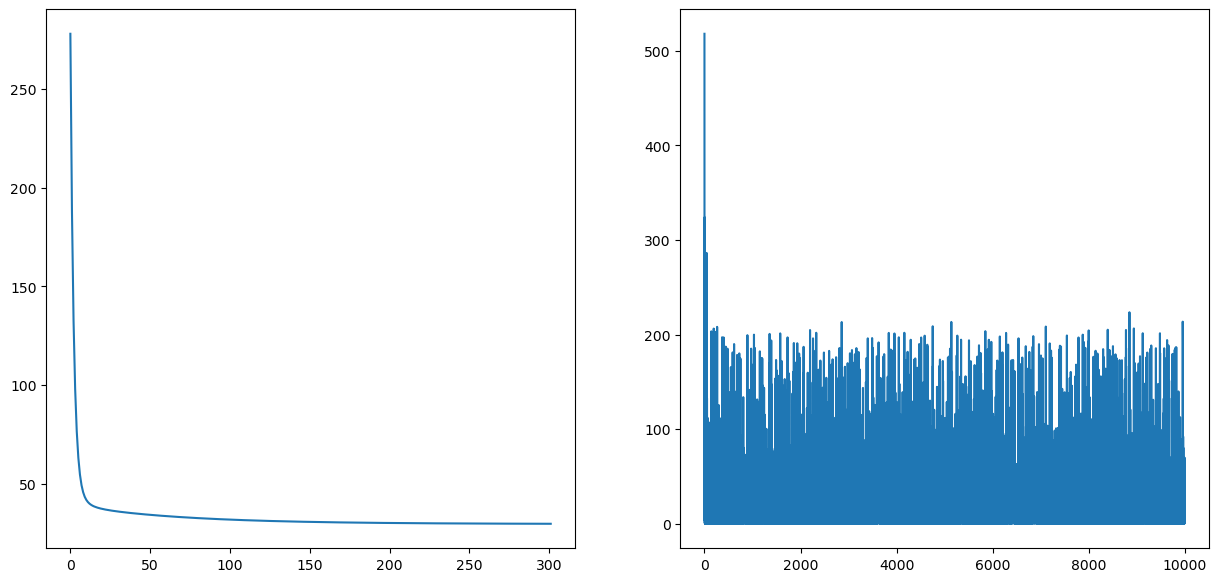

In [68]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(cPath_gd);
ax2.plot(cPath_sgd);

---

# Mini-Batch GD

So far we've seen GD, which uses all $N$-many examples in **each** iteration, and SGD which uses **$1$ example** per iteration. Well, right in between is **mini-batch** GD which uses a **`batch-size`-many** examples per iteration! 

Typically, this `batch_size` could be from $2-512$, sticking to powers of two, in the real world depending on the size of the each example, how much memory you have, etc. 

In [69]:
import inspect
print(inspect.getsource(cost))
print(inspect.getsource(cost_grad))

def cost(X, y, w):
    return np.linalg.norm(X.dot(w)-y,axis=0)**2/X.shape[0]

def cost_grad(X,y,w):
    N = X.shape[0]
    return (2/N)*(X.T.dot(X).dot(w)-X.T.dot(y))



## Implementation

The implementation of mini-batch GD is:

<div class="info">

The **mini-batch GD algorithm** is: 
    
for each `epoch`:

* seperate your data into `N/batch_size`-many batches
* for each `batch` in `batches`
    * $w_{t+1} = w_{t} - \eta \; \nabla C(\mathbf{w}_t,batch)$
    
</div>

This looks familiar! And it should! This is exactly GD, if we only had `N/batch_size` many examples! So the only difference in this algorithm and GD is that here, we process less examples before taking a gradient step! 

In [70]:
def mini_batch_gd(dataset, labels, w_init=None, eta=None, batch_size=10, epochs=5, quiet=False):
    if w_init is None:
        w_init = np.random.rand(dataset.shape[1],1)
    if eta is None:
        eta = 1e-2
        
    # dataset
    N = dataset.shape[0]
    d = dataset.shape[1]

    # calculat our batches
    num_batches = int(N/batch_size)
    
    # clean up initial point sizes:
    w_init = np.asarray(w_init).reshape(d,1)
    
    # mini-batch params 
    delta = 1e-5
    delta_w = 1
    iterations = 0

    # save weights and costs along path
    wPath_mbgd = []
    cPath_mbgd = []
    cPath_mbgd_epoch = []
    
    # take the first step
    w_curr = w_init
    
    # loop through all epochs
    for epoch in range(epochs):
        
        # loop through all batches
        for batch_num in range(num_batches):

            # get current batch
            batch_start = batch_num*batch_size
            batch_end = (batch_num+1)*batch_size
            batch = dataset[batch_start:batch_end,:]
            batch_labels = labels[batch_start:batch_end]

            # run gradient descent on the batch! 
            w_curr,_,_ = gradient_descent(batch, batch_labels, w_init=w_curr, eta=eta, max_iter=1,quiet=True)
 
            
            wPath_mbgd.append(w_curr)
            cPath_mbgd.append(cost(batch,batch_labels,w_curr))
            
            #if not quiet: print(f"Batch:{batch_num+1}/{num_batches}, Loss:{cPath_mbgd[-1]}")
        
        
        if not quiet: print(f"Epoch:{epoch+1}/{epochs}, Loss:{cPath_mbgd[-1]}")
    
    # clean up path variables
    wPath_mbgd = np.squeeze(np.asarray(wPath_mbgd))
    cPath_mbgd = np.squeeze(np.asarray(cPath_mbgd))
    
    return w_curr, wPath_mbgd, cPath_mbgd

## MBGD on Linear Regression

Lets use the setup function we defined above:

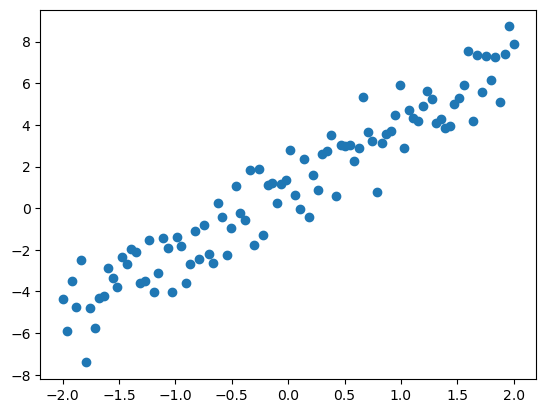

In [71]:
x,X,y,f = lin_reg()
plt.scatter(x,y);

In [72]:
w_gd, wPath_gd, cPath_gd = gradient_descent(X,y,quiet=True)
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y)
w_mbgd, wPath_mbgd, cPath_mbgd = mini_batch_gd(X,y,epochs=100,quiet=True,batch_size=1)

terminating SGD after 4 epochs with weight change of 0.01009.


## Plot it

Lets take a look!

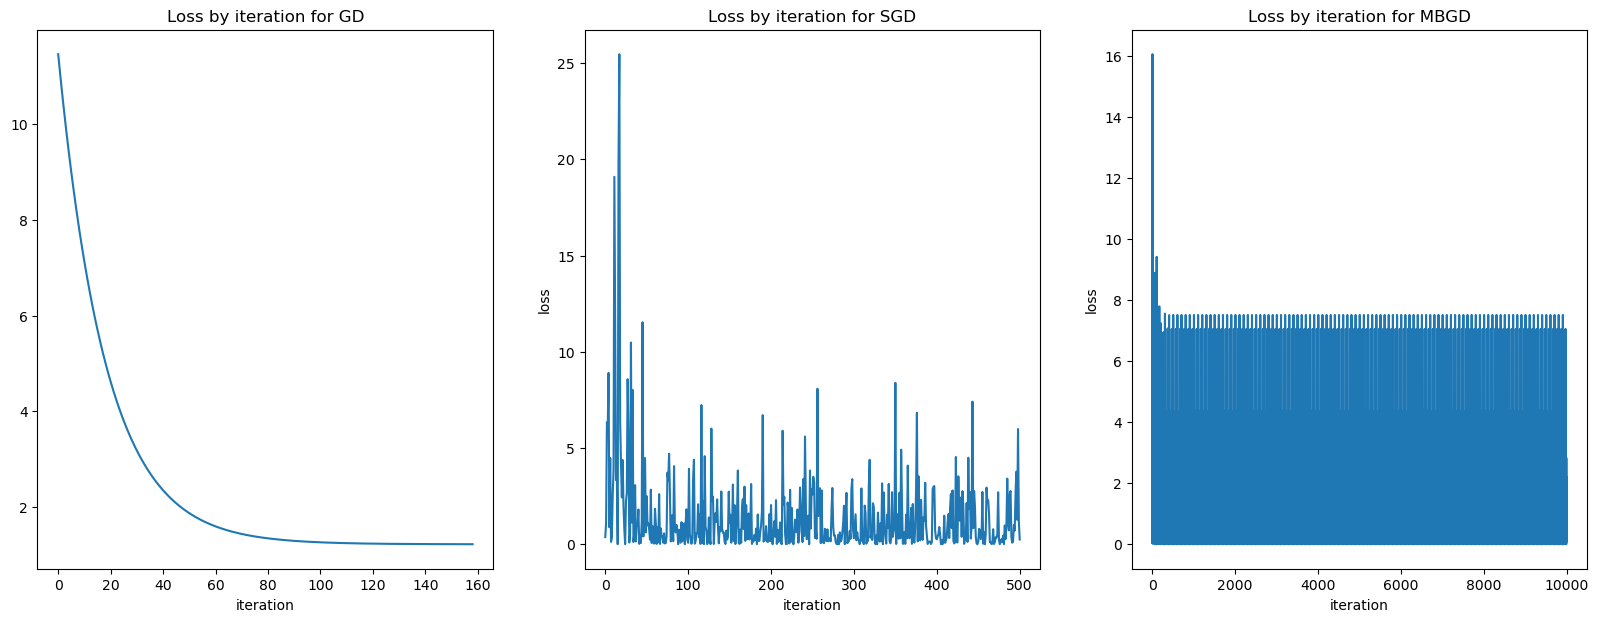

In [73]:
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(131)
ax1.plot(cPath_gd);
ax1.set_title("Loss by iteration for GD")
ax1.set_xlabel("iteration");


ax2 = fig.add_subplot(132)
ax2.plot(cPath_sgd);
ax2.set_title('Loss by iteration for SGD');
ax2.set_xlabel("iteration");
ax2.set_ylabel("loss");

ax3 = fig.add_subplot(133)
ax3.plot(cPath_mbgd);
ax3.set_title('Loss by iteration for MBGD');
ax3.set_xlabel("iteration");
ax3.set_ylabel("loss");


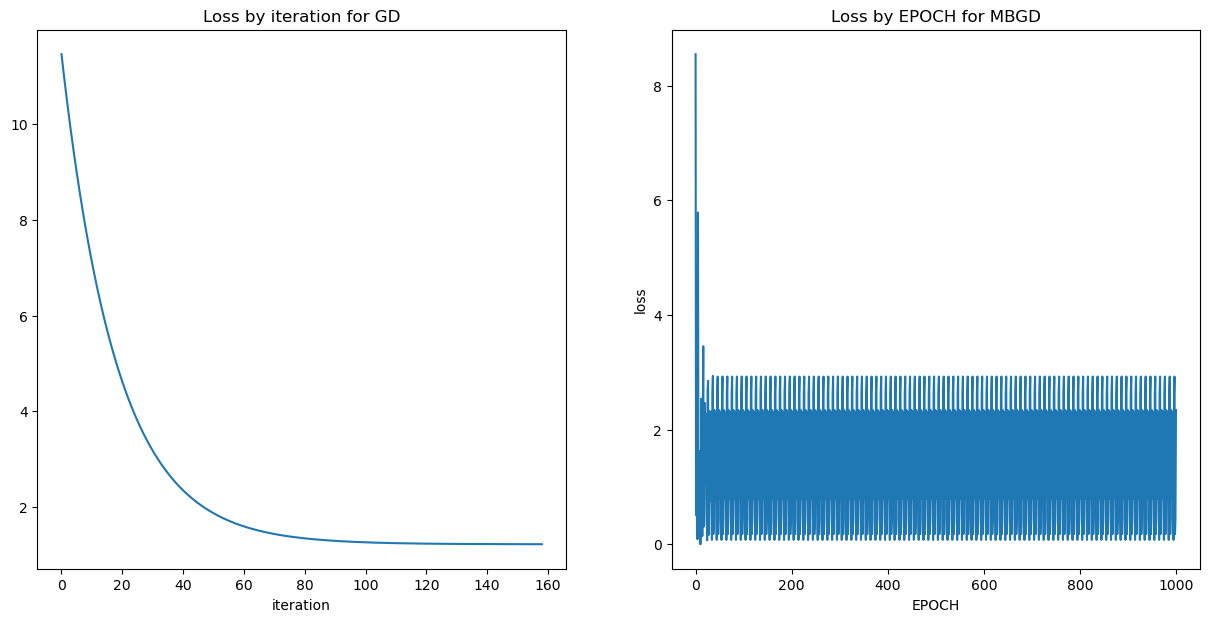

In [74]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
ax1.plot(cPath_gd);
ax1.set_title("Loss by iteration for GD")
ax1.set_xlabel("iteration");


ax2 = fig.add_subplot(122)
ax2.plot(cPath_mbgd[0::10]);
ax2.set_title('Loss by EPOCH for MBGD');
ax2.set_xlabel("EPOCH");
ax2.set_ylabel("loss");

Lets take a look at the paths! 

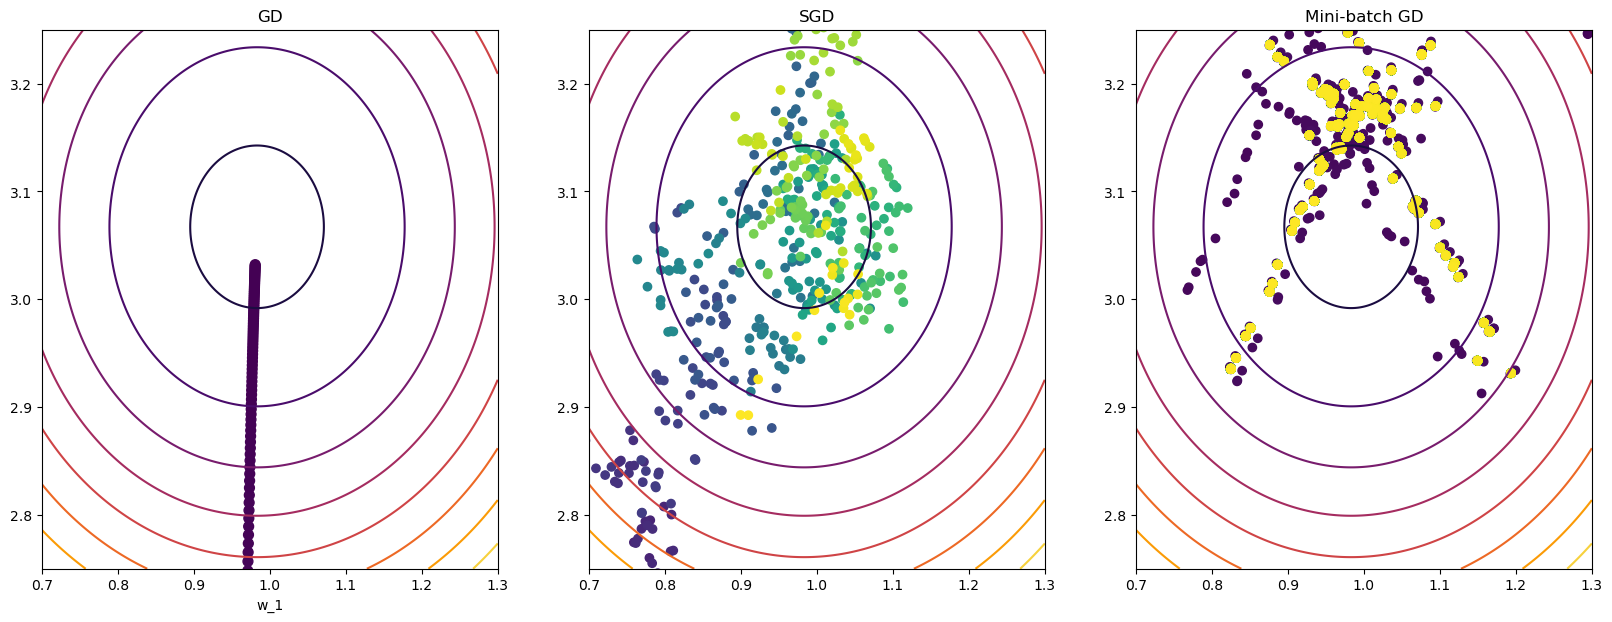

In [75]:
num_points = 300
w_0 = np.linspace(0.7,1.3,num_points)
w_1 = np.linspace(2.75,3.25,num_points)
W_0,W_1 = np.meshgrid(w_0,w_1)
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)
costs = cost(X,y,wgrid).reshape(W_0.shape)

plt.figure(figsize=(20,7));

# Gradient Descent
ax1 = plt.subplot(131)
ax1.contour(W_0, W_1, costs, cmap='inferno');
ax1.set_xlabel('w_0');
ax1.set_xlabel('w_1');
ax1.set_xlim([0.7,1.3])
ax1.set_ylim([2.75,3.25])
ax1.scatter(wPath_gd[:,0],wPath_gd[:,1], s=50,c=cPath_gd);
ax1.set_title("GD");

# SGD
ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
ax2.contour(W_0, W_1, costs, cmap='inferno');
ax2.scatter(wPath_sgd[:,0],wPath_sgd[:,1], c=range(len(wPath_sgd)));
ax2.set_title("SGD");

# MBGD
ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
ax3.contour(W_0, W_1, costs, cmap='inferno');
ax3.scatter(wPath_mbgd[:,0],wPath_mbgd[:,1], c=range(len(wPath_mbgd)));
ax3.set_title("Mini-batch GD");

<div class="info">
    
**Pause-and-ponder**: What do you notice about the graphs above? What can you say about these graphs?

</div>

## MBGD on Polynomial Regression

Lets run this on the polynomial problem

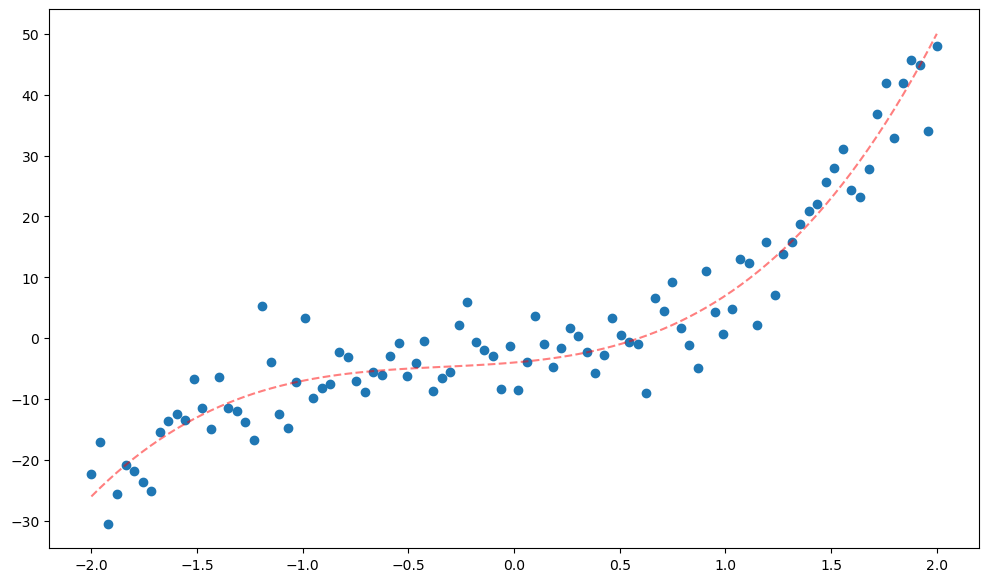

In [76]:
x,X,y,f = poly_reg()
plt.figure(figsize=(12,7))
plt.scatter(x,y);
plt.plot(x,f(x),'--r',alpha=0.5);

In [77]:
w_gd, wPath_gd, cPath_gd = gradient_descent(X,y,quiet=True)
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y)
w_mbgd, wPath_mbgd, cPath_mbgd = mini_batch_gd(X,y,epochs=100,quiet=True)

terminating SGD after 4 epochs with weight change of 0.01274.


## Plot it!

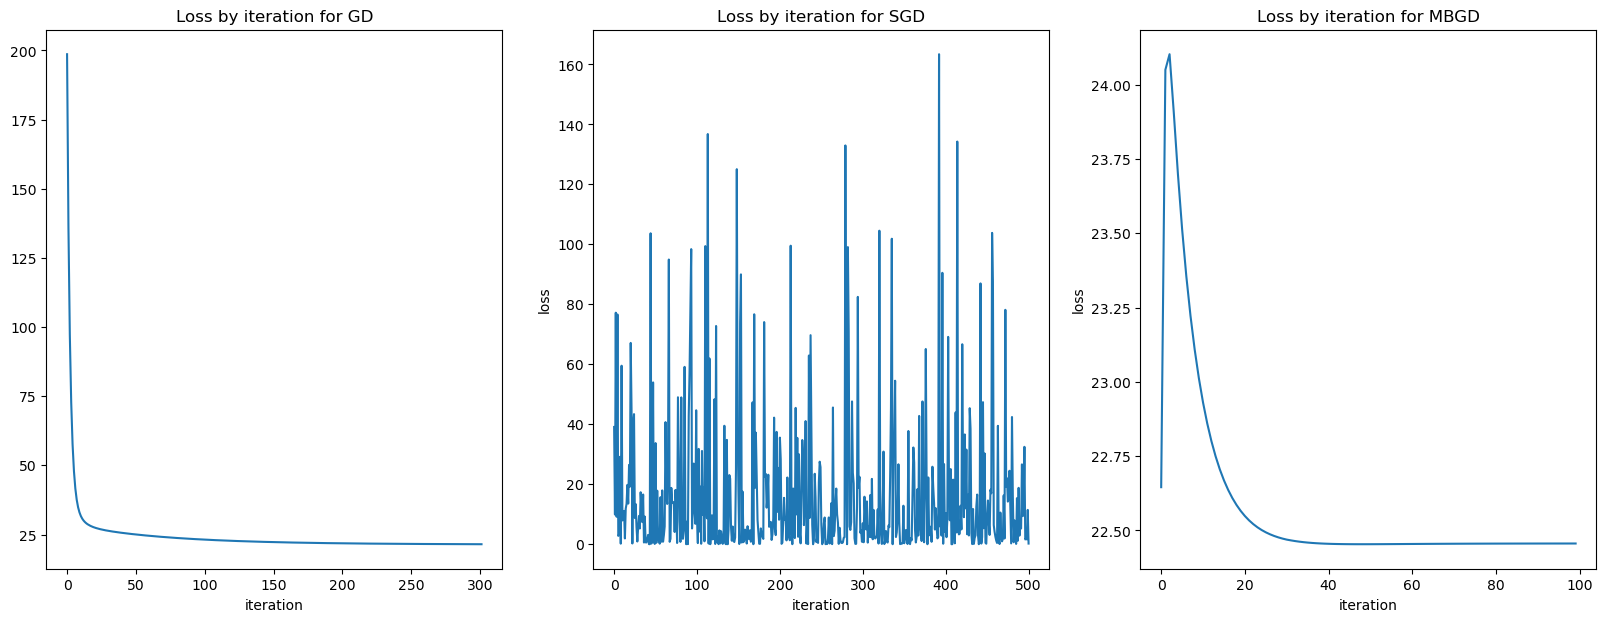

In [78]:
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(131)
ax1.plot(cPath_gd);
ax1.set_title("Loss by iteration for GD")
ax1.set_xlabel("iteration");


ax2 = fig.add_subplot(132)
ax2.plot(cPath_sgd);
ax2.set_title('Loss by iteration for SGD');
ax2.set_xlabel("iteration");
ax2.set_ylabel("loss");

ax3 = fig.add_subplot(133)
ax3.plot(cPath_mbgd[::10]);
ax3.set_title('Loss by iteration for MBGD');
ax3.set_xlabel("iteration");
ax3.set_ylabel("loss");


Now lets look at by **epoch** for MBSGD

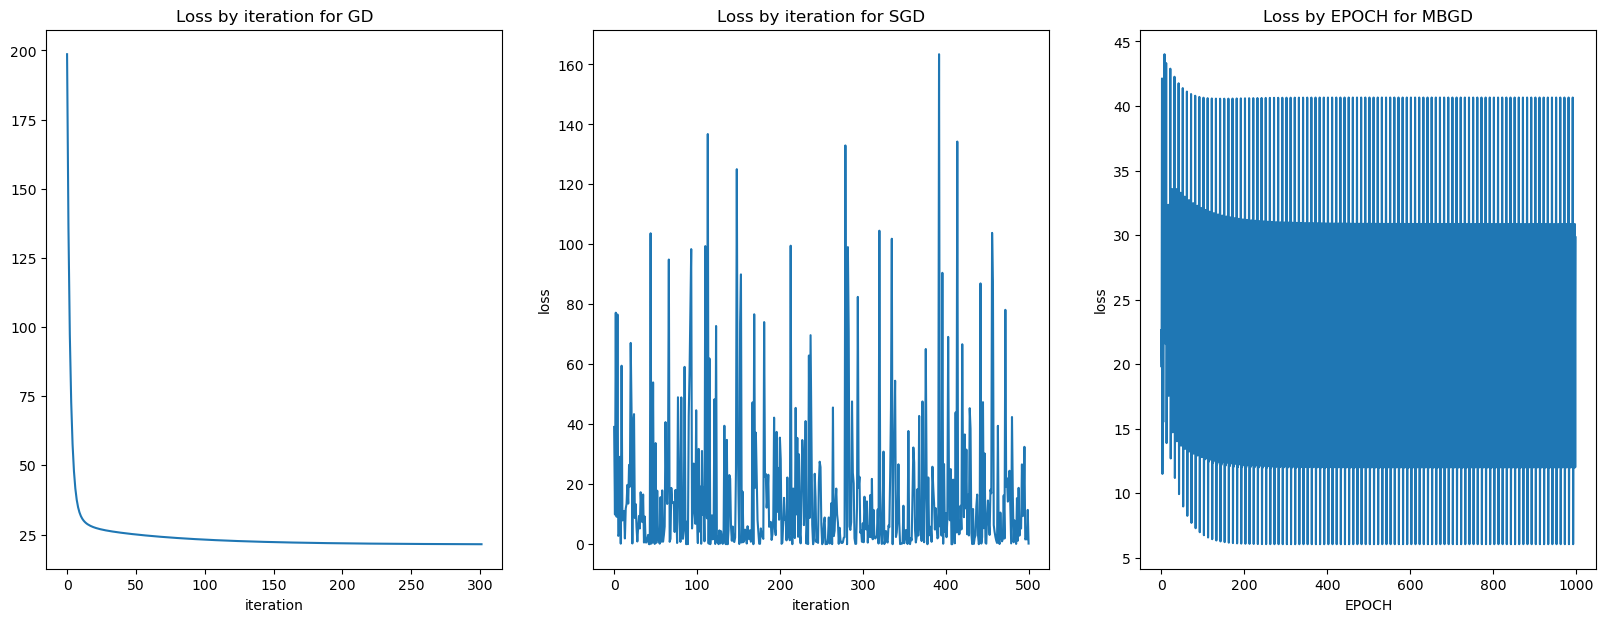

In [79]:
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(131)
ax1.plot(cPath_gd);
ax1.set_title("Loss by iteration for GD")
ax1.set_xlabel("iteration");


ax2 = fig.add_subplot(132)
ax2.plot(cPath_sgd);
ax2.set_title('Loss by iteration for SGD');
ax2.set_xlabel("iteration");
ax2.set_ylabel("loss");

ax3 = fig.add_subplot(133)
ax3.plot(cPath_mbgd);
ax3.set_title('Loss by EPOCH for MBGD');
ax3.set_xlabel("EPOCH");
ax3.set_ylabel("loss");

In [80]:
ax3 = fig.add_subplot(133)
ax3.plot(cPath_mbgd);
ax3.set_title('Loss by EPOCH for MBGD');
ax3.set_xlabel("EPOCH");
ax3.set_ylabel("loss");

How about those paths!

In [51]:
if regenerate_anim:
    fig = plt.figure(figsize=(30,7))

    ax1 = fig.add_subplot(131)
    ax1.scatter(x,y);

    ax2 = fig.add_subplot(132)
    ax2.scatter(x,y);

    ax3 = fig.add_subplot(133)
    ax3.scatter(x,y);



    line1, = ax1.plot([],[],'--r')
    line2, = ax2.plot([],[],'--r')
    line3, = ax3.plot([],[],'--r')


    num_frames = 50
    gd_frames = np.linspace(0,len(wPath_gd)-1,num_frames).astype(int)
    sgd_frames = np.linspace(0,len(wPath_sgd)-1,num_frames).astype(int)
    mbgd_frames = np.linspace(0,len(wPath_mbgd)-1,num_frames).astype(int)


    def animate(i):
        gd_frame = gd_frames[i]
        sgd_frame = sgd_frames[i]
        mbgd_frame = sgd_frames[i]


        coefs_gd = np.flip(np.squeeze(wPath_gd[gd_frame]))
        coefs_sgd = np.flip(np.squeeze(wPath_sgd[sgd_frame]))
        coefs_mbgd = np.flip(np.squeeze(wPath_mbgd[mbgd_frame]))

        poly_gd = np.poly1d(coefs_gd)
        poly_sgd = np.poly1d(coefs_sgd)
        poly_mbgd = np.poly1d(coefs_mbgd)

        line1.set_data(x,poly_gd(x));
        ax1.set_title('GDIteration: %d - %.2f x^3 + %.2f x^2 + %.2f x + %.2f' % (i, coefs_gd[0], coefs_gd[1], coefs_gd[2], coefs_gd[3]))

        line2.set_data(x,poly_sgd(x));
        ax2.set_title('SGD Iteration: %d - %.2f x^3 + %.2f x^2 + %.2f x + %.2f' % (i, coefs_sgd[0], coefs_sgd[1], coefs_sgd[2], coefs_sgd[3]))

        line3.set_data(x,poly_mbgd(x));
        ax3.set_title('MBGD Iteration: %d - %.2f x^3 + %.2f x^2 + %.2f x + %.2f' % (i, coefs_mbgd[0], coefs_mbgd[1], coefs_mbgd[2], coefs_mbgd[3]))

        return line1, line2, line3

    plt.close()
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=num_frames, interval=100)
    # HTML(anim.to_html5_video())
    anim.save('multi_lin_reg_mbgd.mp4')
    
Video('multi_lin_reg_mbgd.mp4',width=800)

<div class="info">
    
**Pause-and-ponder**: What do you notice about these graphs? Reflect on it and answer here! 
    
</div>

# Momentum

Now we are finally armed with enough to consider modern modifications on these schemes! The first of which is adding some **momentum** to SGD. 

<div class="info">

The **momentum-method** (SGD+Momentum) algorithm is given by:

$$
\begin{align}
z_{k+1} &= \beta z_k + \nabla f(w_k) \\
w_{k+1} &= w_k  - \eta z_{k+1}
\end{align}
$$

</div>

Its not as complicated as you might first think! Lets quickly discover a special case: 

<div class="info">

**Pause-and-ponder**: What do you get when you set the momentum parameter $\beta = 0$?

</div>

Quickly, we shoud see that we recover the original gradient descent iterates. So what does $\beta != 0$ give us? Well in optimization this is called **acceleration**. 

It gives our iterates some "memory". Lets write out a few steps to see what we mean:

$$
\begin{align}
w_1 &= w_0 - \eta z_1, \quad\quad z_1 = \nabla f(w_0) \\
w_2 &= w_1 - \eta z_2, \quad\quad z_2 = \beta\cdot\nabla f(w_0) + \nabla f(w_1) \\
w_3 &= w_2 - \eta z_3, \quad\quad z_3 = \beta \cdot z_2 + \nabla f(w_3) = \beta \cdot (\beta\cdot\nabla f(w_0) + \nabla f(w_1)) + \nabla f(w_2)\\
\ldots
\end{align}
$$

Its named **momentum** by analogy to the concept of *momentum* in physics. We can think of the weight vector $w$ as a *particle* traveling through parameter space. This particle incurs some **acceleration** from the gradient of the loss (which acts as the "force" on the particle). 

This acceleration tends to keep the weight vector traveling **in the same direction** as it was, and can preventing succumbing to unwanted oscillations.

## Implementation

In [82]:
def sgd_momentum(dataset, labels, w_init=None, eta=None, beta=None, epochs=5):
    if w_init is None:
        w_init = np.random.rand(dataset.shape[1],1)
    if eta is None:
        eta = 1e-2
    if beta is None:
        beta = 0.1
        
    # dataset
    N = dataset.shape[0]
    d = dataset.shape[1]
    
    # clean up initial point sizes:
    w_init = np.asarray(w_init).reshape(d,1)
    
    # M-SGD params
    delta = 1e-10
    delta_w = 1
    max_iter = 1000
    iterations = 0

    # save weights and costs along path
    wPath = [w_init]

    # calc cost at that initial value
    idx = np.random.randint(N)
    x_i = dataset[np.newaxis,idx,:].T
    y_i = labels[idx,:]
    cPath = [cost_sgd(x_i,y_i,w_init)]
        
    # take first step
    w_old = w_init
    z_old = 0
    
    # epochs of training
    for epoch in range(epochs):
        
        # shuffle the dataset - note we do this by shuffling indices
        indices = np.random.permutation(N)
        shuffled_dataset = dataset[indices,:]
        shuffled_labels = labels[indices,:]
        
        for i in range(N):
            # np.newaxis is there to deal with the 1 for the row size
            curr_sample = shuffled_dataset[i,:]
            curr_sample = curr_sample[np.newaxis].T
            curr_label = shuffled_labels[i,:]
            
            # update your weights with the grad at one sample
            grad = cost_grad_sgd(curr_sample,curr_label,w_old)
            z_new = beta*z_old + grad
            w_new = w_old - eta * z_new
            
            # update paths
            wPath.append(w_new)
            cPath.append(cost_sgd(curr_sample,curr_label,w_new))
            
            # calculate weight change
            delta_w = np.linalg.norm(w_new - w_old)
            
            # make your previous new weights the current weights
            w_old = w_new
            z_old = z_new
        
        # at end of epoch, check to see if you should terminate
        if delta_w < delta:
            break
    
    # clean up path variables
    wPath = np.squeeze(np.asarray(wPath))
    cPath = np.squeeze(np.asarray(cPath))
    
    print(f"terminating M-SGD after {epoch} epochs with weight change of {delta_w:0.5f}.")
    
    return w_new, wPath, cPath

## M-SGD on Linear Regression

In [83]:
def lin_reg():
    def f(x):
        return 3*x + 1
    N = 100
    x = np.linspace(-2,2,N)
    y = f(x) + np.random.randn(N) # our zero man gaussian noise
    
    X = np.ones((N,2))
    X[:,1] = x
    
    y = y[:,np.newaxis]

    return x,X,y,f

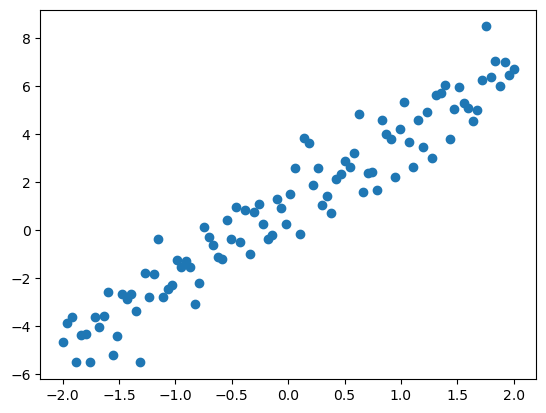

In [84]:
x,X,y,f = lin_reg()
plt.scatter(x,y);

In [85]:
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=[0.75,2.5],eta=1e-2,epochs=100)
w_sgd_m, wPath_sgd_m, cPath_sgd_m = sgd_momentum(X,y,w_init=[0.75,2.5],eta=1e-5,epochs=100,beta=0.9)

terminating SGD after 99 epochs with weight change of 0.00242.
terminating M-SGD after 99 epochs with weight change of 0.00006.


## Plot it!

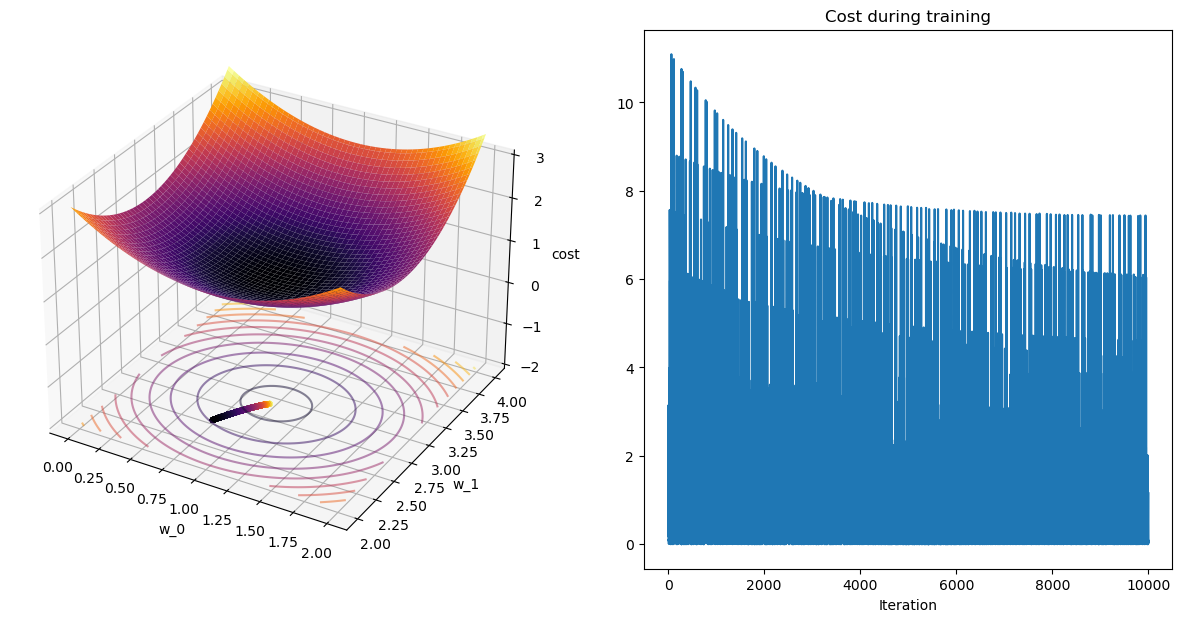

In [86]:
plot_path(wPath_sgd_m,cPath_sgd_m,colorby='iter')

## Comparison

terminating SGD after 99 epochs with weight change of 0.00094.
terminating M-SGD after 99 epochs with weight change of 0.00831.


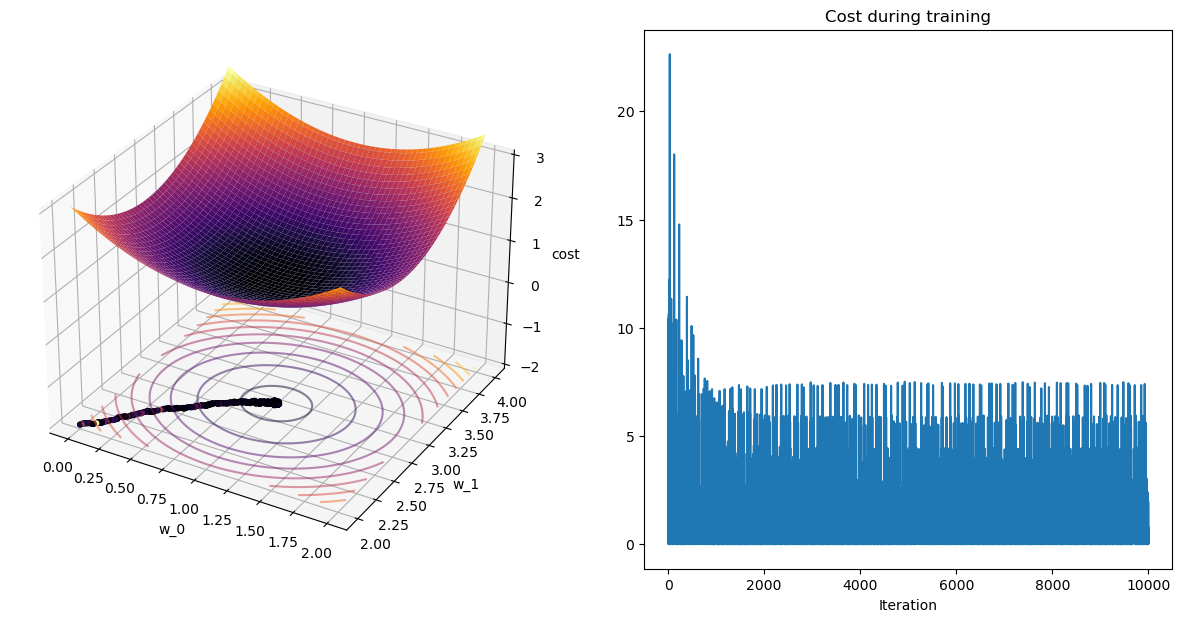

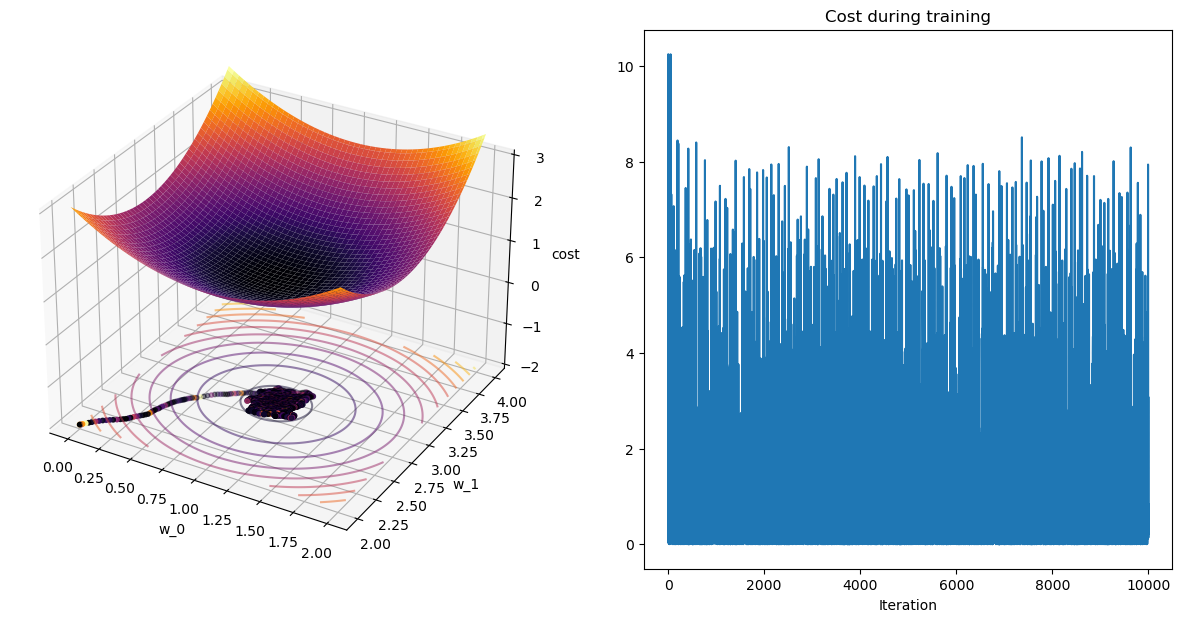

In [87]:
w_init=[0,2]
eta=1e-3
beta=0.9

w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=w_init,eta=eta,epochs=100)
w_sgd_m, wPath_sgd_m, cPath_sgd_m = sgd_momentum(X,y,w_init=w_init,eta=eta,beta=beta,epochs=100)

plot_path(wPath_sgd,cPath_sgd);
plot_path(wPath_sgd_m,cPath_sgd_m);

## Plot Paths!

In [88]:
w_init=[0,2]
eta=1e-4
beta=0.99

w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=w_init,eta=eta,epochs=100)
w_sgd_m, wPath_sgd_m, cPath_sgd_m = sgd_momentum(X,y,w_init=w_init,eta=eta,beta=beta,epochs=100)

terminating SGD after 99 epochs with weight change of 0.00001.
terminating M-SGD after 99 epochs with weight change of 0.00168.


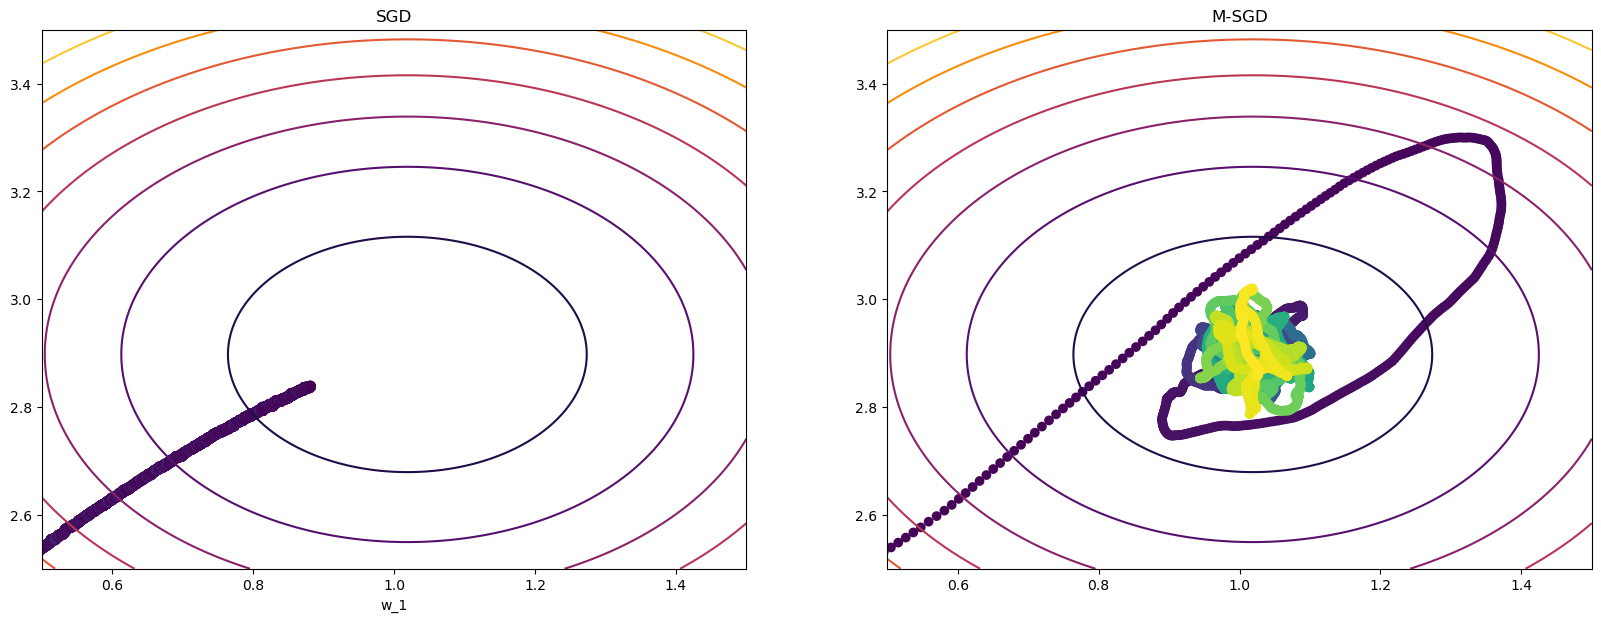

In [89]:
# plot
num_points = 300

x_l = 0.5
x_r = 1.5
y_l = 2.5
y_r = 3.5

w_0 = np.linspace(x_l,x_r,num_points)
w_1 = np.linspace(y_l,y_r,num_points)
W_0,W_1 = np.meshgrid(w_0,w_1)
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)
costs = cost(X,y,wgrid).reshape(W_0.shape)

plt.figure(figsize=(20,7));

# SGD
ax1 = plt.subplot(121)
ax1.contour(W_0, W_1, costs, cmap='inferno');
ax1.set_xlabel('w_0');
ax1.set_xlabel('w_1');
ax1.set_xlim([x_l,x_r])
ax1.set_ylim([y_l,y_r])
ax1.scatter(wPath_sgd[:,0],wPath_sgd[:,1], s=50,c=cPath_sgd);
ax1.set_title("SGD");

# MSGD
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
ax2.contour(W_0, W_1, costs, cmap='inferno');
ax2.scatter(wPath_sgd_m[:,0],wPath_sgd_m[:,1], c=range(len(wPath_sgd_m)));
ax2.set_title("M-SGD");

<div class="info">
    
**Pause-and-ponder**: What do you notice? Go back and change the $\eta$ and $\beta$ parameters above and jot your observations down here!
    
</div>
    

## GD + Momentum 

<div class="info">
    
**See-and-do**: Go back, and add some momentum to our stock GD implementation, and make your comparisons!
    
</div>
    

In [90]:
def gd_momentum():
    # EDIT HERE!
    return

## MBGD + Momentum

<div class="info">
    
**See-and-do**: Go back, and add some momentum to our Mini-batch GD implementation, and make your comparisons!
    
</div>
    

In [91]:
def mbgd_momentum():
    # EDIT HERE!
    return

# Unified Implementation

So far, we've implemented the following:

* Gradient Descent
* Stochastic Gradient Descent
* Mini-batch GD

What about "Mini-batch SGD"? How would you implement it? What would you expect it to behave like?


To the methods above, we can imagine adding some **momentum**, giving us:
* GD + Momentum
* Stochastic Gradient Descent + Momentum
* Mini-batch GD + Momentum

Of which we've only given one, but tasked you with the rest. 

Armed with everything you know, you should now be able to give me **one function** which can do all of these things! Among other things, this function should take a `batch_size`, an `epoch`, an `eta`, and a `beta` parameter. 

In [92]:
def gd_optimizer():
    # EDIT HERE
    return

# RMS Prop

Another extension which aims to curb our steps sizes in "bad directions" is RMS Prop which stands for Root Mean Squared Propagation. The name makes it sound more complicated than it is! Its updates are:


$$
\begin{align}
v_{t+1} = \gamma v_{t} + (1-\gamma)\left(\nabla f(w_t)\right)^2
\end{align} \\
w_{t+1} = w_{t} - \frac{\eta}{\sqrt{v_{t+1}}}\nabla f(w_t)
$$

Where $\gamma$ is called the **forgetting factor**. 

This algorithm **scales** the step-size/learning rate differently for each parameter! It does so automatically through this scaling! 

Factoid: This algorithm was first propsoed by Geoff Hinton while teaching a Coursera course! 

## Implementation

In [93]:
def mini_batch_rmsprop(dataset, labels, w_init=None, eta=None, gamma=None, batch_size=10, epochs=5, quiet=False):
    if w_init is None:
        w_init = np.random.rand(dataset.shape[1],1)
    if eta is None:
        eta = 1e-2
    if gamma is None:
        gamma = 0.9
        
    # dataset
    N = dataset.shape[0]
    d = dataset.shape[1]

    num_batches = int(N/batch_size)
    
    # clean up initial point sizes:
    w_init = np.asarray(w_init).reshape(d,1)
    
    # mini-batch params 
    delta = 1e-5
    delta_w = 1
    iterations = 0

    # save weights and costs along path
    wPath_rms = []
    cPath_rms = []
    
    # take the first step
    w_old = w_init
    v_old = 0
    
    for epoch in range(epochs):
        
        for batch_num in range(num_batches):

            # get current batch
            batch_start = batch_num*batch_size
            batch_end = (batch_num+1)*batch_size
            batch = dataset[batch_start:batch_end,:]
            batch_labels = labels[batch_start:batch_end]

            # update your weights
            grad = cost_grad(batch,batch_labels,w_old)
            
            v_new = gamma*v_old + (1-gamma)*grad**2
            w_new = w_old - (eta/np.sqrt(v_new + np.random.rand()))*grad 
 

            # update old weights
            w_old = w_new
            v_old = v_new
            
            # append trajectory
            wPath_rms.append(w_new)
            cPath_rms.append(cost(batch,batch_labels,w_new))
            
    
        if not quiet: print(f"Epoch:{epoch+1}/{epochs}, Loss:{cPath_rms[-1]}")
    
    # clean up path variables
    wPath_rms = np.squeeze(np.asarray(wPath_rms))
    cPath_rms = np.squeeze(np.asarray(cPath_rms))
    
    return w_new, wPath_rms, cPath_rms

## Plot it!

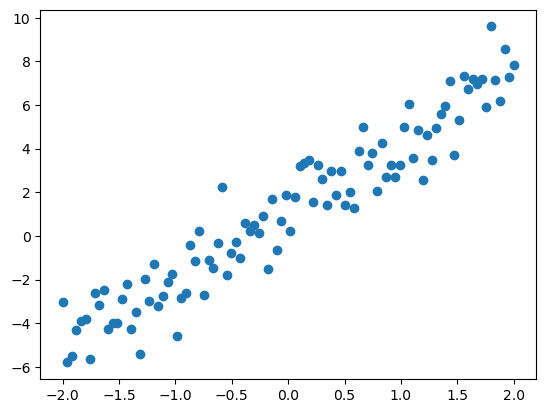

In [94]:
x,X,y,f = lin_reg()
plt.scatter(x,y);

In [95]:
gamma = 0.8
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=[0.75,2.5],eta=1e-2,epochs=100)
w_rms, wPath_rms, cPath_rms = mini_batch_rmsprop(X,y,w_init=[0.75,2.5],eta=1e-2,gamma=gamma,epochs=100,quiet=True)

terminating SGD after 99 epochs with weight change of 0.01311.


terminating SGD after 99 epochs with weight change of 0.04209.


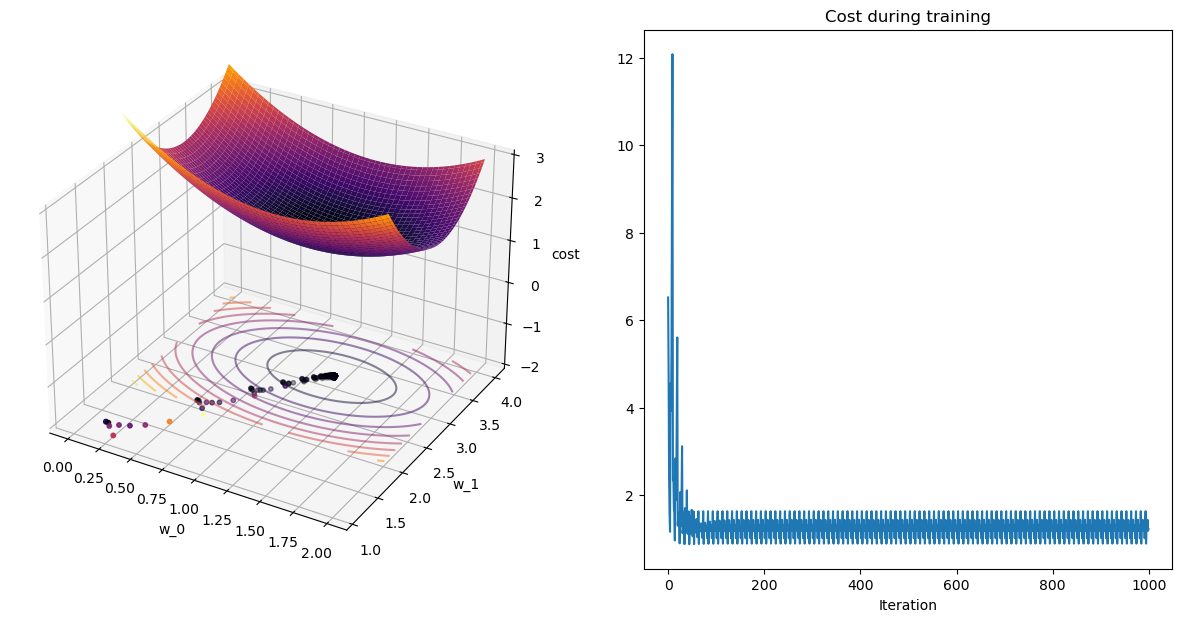

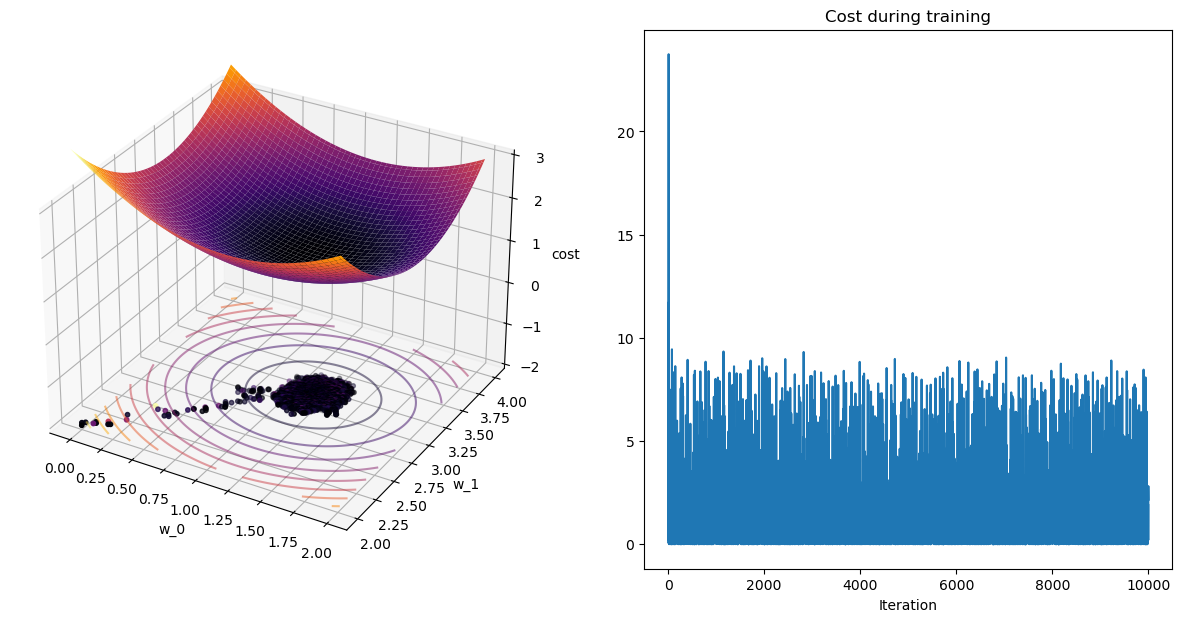

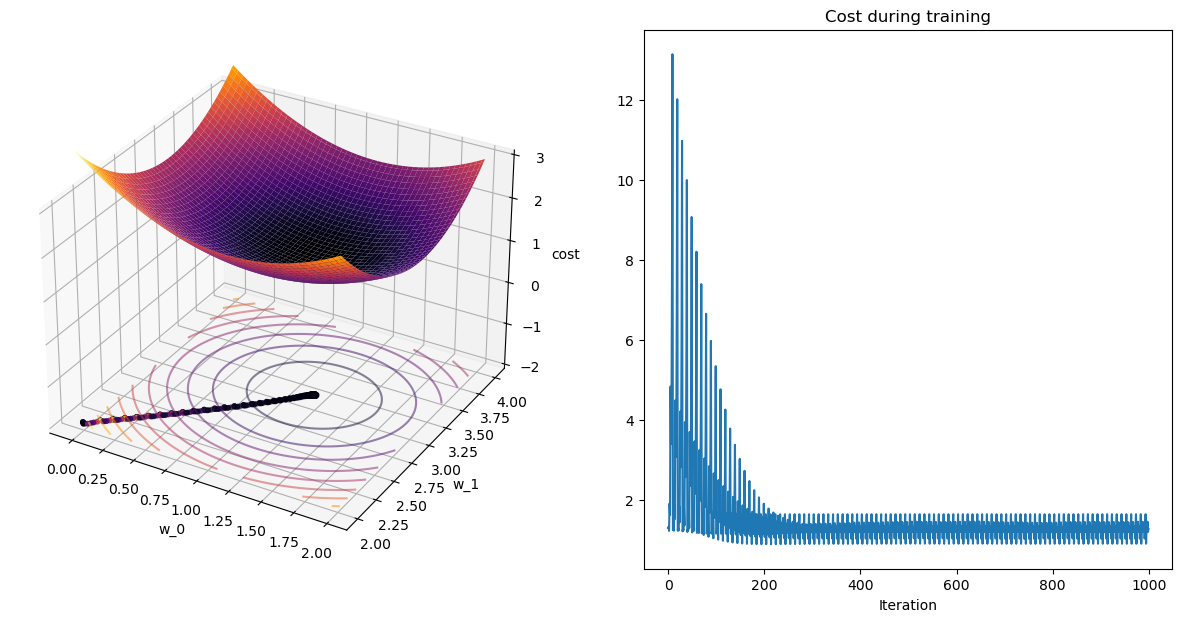

In [96]:
w_init=[0,2]
eta=1e-2
gamma=0.8

w_mbgd, wPath_mbgd, cPath_mbgd = mini_batch_gd(X,y,epochs=100,quiet=True)
w_sgd, wPath_sgd, cPath_sgd = sgd(X,y,w_init=w_init,eta=eta,epochs=100)
w_rms, wPath_rms, cPath_rms = mini_batch_rmsprop(X,y,w_init=w_init,eta=eta,gamma=gamma,epochs=100,quiet=True)

plot_path(wPath_mbgd,cPath_mbgd);
plot_path(wPath_sgd,cPath_sgd);
plot_path(wPath_rms,cPath_rms);

# Adam

Finally - we've made it! A modern algorithm! At a very basic level, ADAM is just momentum+rmsprop! You could implement it right now!

Before we give its update, lets explain what ADAM stands for: **ADA**ptive **M**oment estimation. Well, if you think of the gradient as the thing we are estimating, then its average of a dataset is the "first moment", or the **mean**. The square of that is the "second moment". 

So my combining momentum, which deals with the first moment, and RMSProp which deals with the second moment, we have ADAM.

<div class="info">
The ADAM algorithm updates are:

$$
\require{cancel}
\begin{align}
z_{t+1} &= \frac{\beta_1 z_t + (1-\beta_1)\nabla f(w_t)}{\color{red}{\cancel{1-\beta_1^t}}} \\
v_{t+1} &= \frac{\beta_2 v_{t} + (1-\beta_2)\left(\nabla f(w_t)\right)^2}{\color{red}{\cancel{1-\beta_2^t}}} \\
w_{t+1} &= w_{t} - \eta\frac{z_{t+1}}{\color{red}{\sqrt{v_{t+1}} + \epsilon}}\color{red}{\cancel{\nabla f(w_t)}}
\end{align}
$$
     
**Notes:** 
* **Note**: Let $\epsilon$ be a small, but **fixed** number like $10^{-8}$.
* We are giving it in the "usual" convention in terms of parameters, so $\beta_1$ controls the amount of "momentum", while $\beta_2$ controls the amount of "RMSprop".
* ~~We are also giving the usual ADAM implementation that includes the **bias correction** of dividing by $\cancel{1-\beta^t}$. As $t$ grows, this corrective term disappears.~~
* "In the field" typical values for $\beta_1,\beta_2$ are: $\beta_1=0.9,\beta_2=0.999$, and $\eta$ still needs to be tuned.
* **Note**: You should still try different values here! These are "in the field" values for "real" cost functions.

 
</div>

In [97]:
def mini_batch_adam(dataset, labels, w_init=None, eta=None, beta1=0.9, beta2=0.999, batch_size=10, epochs=5, quiet=False):
    if w_init is None:
        w_init = np.random.rand(dataset.shape[1],1)
    if eta is None:
        eta = 1e-2
    epsilon = 1e-8
        
    # dataset
    N = dataset.shape[0]
    d = dataset.shape[1]

    num_batches = int(N/batch_size)
    
    # clean up initial point sizes:
    w_init = np.asarray(w_init).reshape(d,1)
    
    # mini-batch params 
    delta = 1e-5
    delta_w = 1
    iterations = 0

    # save weights and costs along path
    wPath_adam = []
    cPath_adam = []
    
    # take the first step
    w_old = w_init
    z_old = 0
    v_old = 0
    
    t = 1
    for epoch in range(epochs):
        
        for batch_num in range(num_batches):

            # get current batch
            batch_start = batch_num*batch_size
            batch_end = (batch_num+1)*batch_size
            batch = dataset[batch_start:batch_end,:]
            batch_labels = labels[batch_start:batch_end]

            # update your weights
            grad = cost_grad(batch,batch_labels,w_old)
            
            z_new = beta1*z_old + (1-beta1)*grad
            z_corr = z_new/(1+beta1**t)
            v_new = beta2*v_old + (1-beta2)*grad**2
            v_corr = v_new/(1+beta2**t)
            w_new = w_old - eta*z_corr/(np.sqrt(v_corr) + epsilon)
 

            # update old weights
            w_old = w_new
            z_old = z_new
            v_old = v_new
            
            # increment t
            t += 1
            
            # append trajectory
            wPath_adam.append(w_new)
            cPath_adam.append(cost(batch,batch_labels,w_new))
            
    
        if not quiet: print(f"Epoch:{epoch+1}/{epochs}, Loss:{cPath_adam[-1]}")
    
    # clean up path variables
    wPath_adam = np.squeeze(np.asarray(wPath_adam))
    cPath_adam = np.squeeze(np.asarray(cPath_adam))
    
    return w_new, wPath_adam, cPath_adam

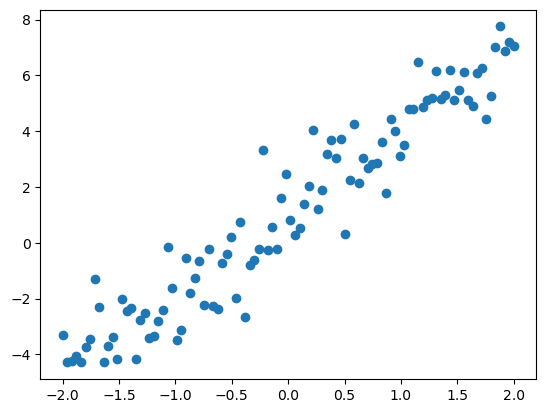

In [98]:
x,X,y,f = lin_reg()
plt.scatter(x,y);

In [99]:
w_init=[0.1,2.1]
eta=1e-2

w_adam, wPath_adam, cPath_adam = mini_batch_adam(X,y,w_init=w_init,eta=eta,epochs=100,quiet=True)

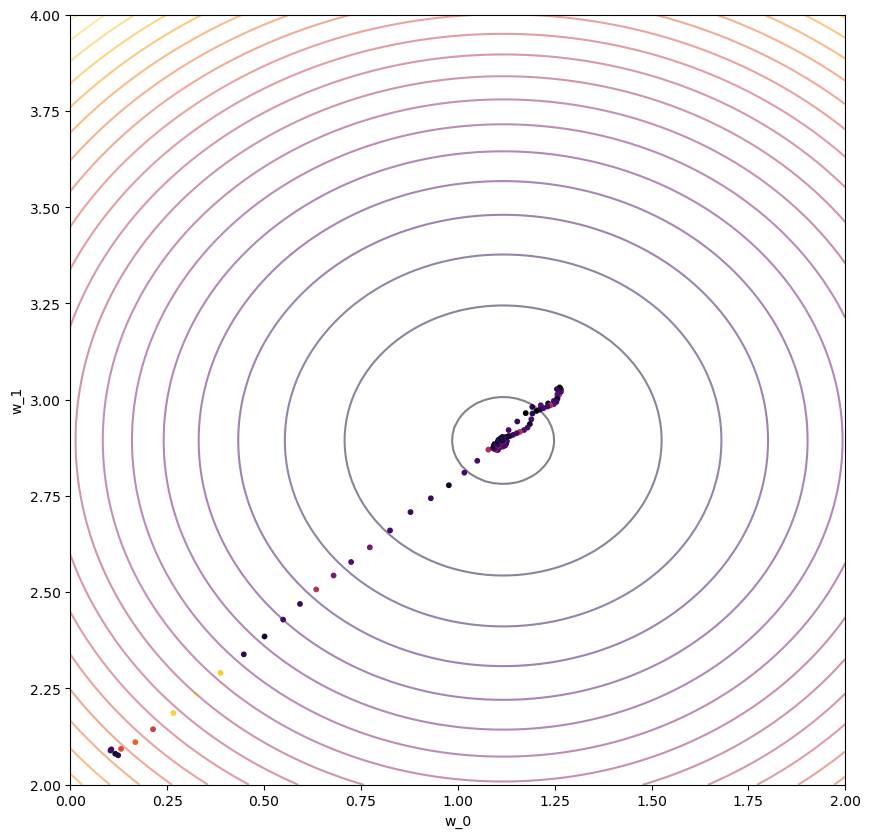

In [100]:
# plotting
len_w = 100
w_0 = np.linspace(0,2,len_w)
w_1 = np.linspace(2,4,len_w)
W_0, W_1 = np.meshgrid(w_0, w_1)

# combine and reshape mesh for calculation
wgrid = np.array([W_0,W_1]).reshape(2, len(w_0)**2)

# calculate on grid, and reshape back for plotting
costs = cost(X,y,wgrid).reshape(W_0.shape)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('w_0')
ax1.set_ylabel('w_1')
# ax1.set_zlabel('cost')
# ax1.set_zlim([-2,3])
ax1.scatter(wPath_adam[:,0],wPath_adam[:,1],s=10,c=cPath_adam,cmap='inferno');
#ax1.plot(wPath_adam[:,0],wPath_adam[:,1]);
# ax1.plot_surface(W_0, W_1, costs,cmap='inferno');
ax1.contour(W_0, W_1, costs, cmap='inferno',levels=20,alpha=0.5);